In [1]:
%matplotlib notebook
import matplotlib
import seaborn as sb
from matplotlib import pyplot as plt
import numpy as np

# Jupyter Specifics
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [2]:
from Cluster import *

Getting data:
getting JHU data...
number of countries listed 274
done with JHU data.  Got  274 countries.
getting owid data...
data for population changes only slowly if at all in OWID database
done with owid data. Got 212 countries
WHO acute file found dictionary acute_who
ICU file found dictionary icus_2012
---------------------------------
Done with data.
---------------------------------
Getting deaths, case and testing data...
done.
doing piecwise linear fits to testing data ...
done.
making cases with nonlinear testing adjustment...
done.
to change the nonlinear correction function, call make_cases_adj_nonlin(K), K=2 by default


In [3]:
datasets = ['deaths','cases','cases_lin2020','cases_pwlfit','cases_nonlin']

d_countries = [c for c in clusdata_all['deaths']]
c_countries = [c for c in clusdata_all['cases']]
lc_countries = [c for c in clusdata_all['cases_lin2020']]
pc_countries = [c for c in clusdata_all['cases_pwlfit']]
nc_countries = [c for c in clusdata_all['cases_nonlin']]

countries = d_countries

In [4]:
# check that all country sets being used are the same and check time series lengths and starting dates
countrysets = [d_countries,c_countries,lc_countries,pc_countries,nc_countries]
print([len(ccs) for ccs in countrysets])
for ccs1 in countrysets:
    print([ccs1 == ccs2 for ccs2 in countrysets])
print([len(clusdata_all[d1]['United States']) for d1 in datasets])
print(len(total_deaths_x['dates']),len(total_cases_x['dates']),len(testing_x['dates']),total_deaths_x['dates'][0],total_cases_x['dates'][0],testing_x['dates'][0])

[57, 57, 57, 57, 57]
[True, True, True, True, True]
[True, True, True, True, True]
[True, True, True, True, True]
[True, True, True, True, True]
[True, True, True, True, True]
[161, 161, 161, 161, 161]
261 261 261 12/31/19 12/31/19 12/31/19


In [5]:
len(testing_x['dates'])

261

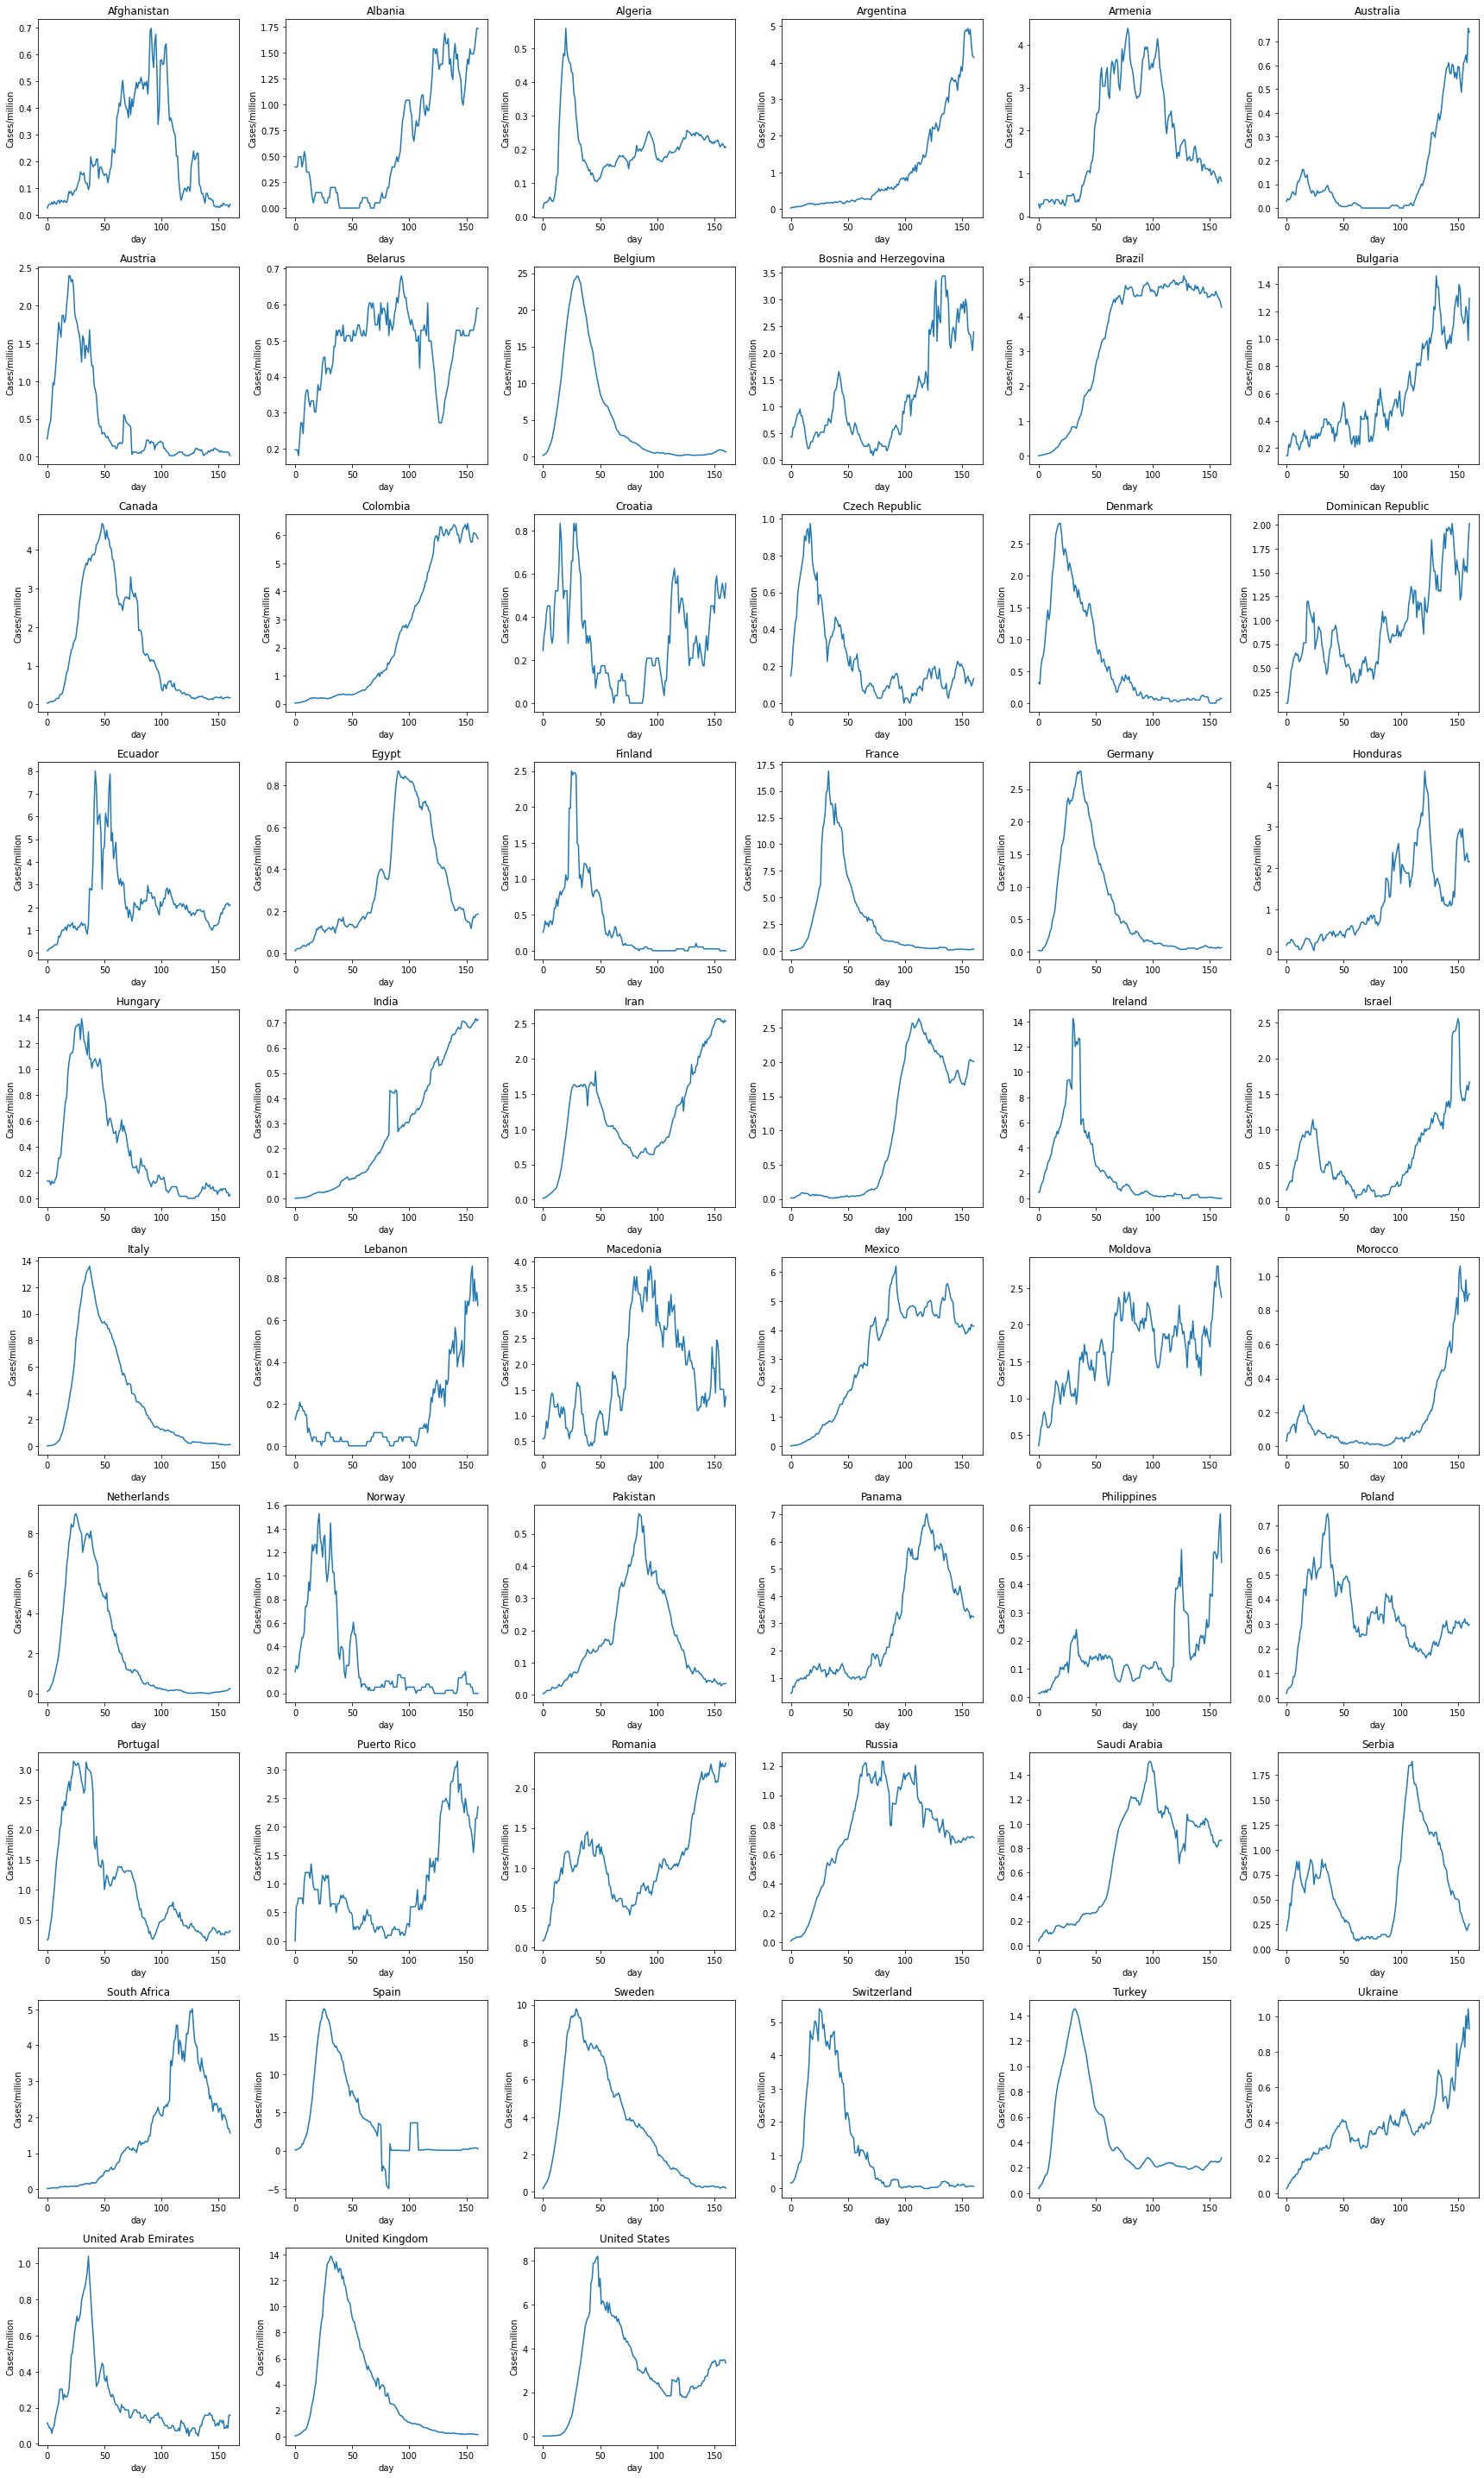

In [6]:
plot_all(countries,clusdata_all['deaths'])

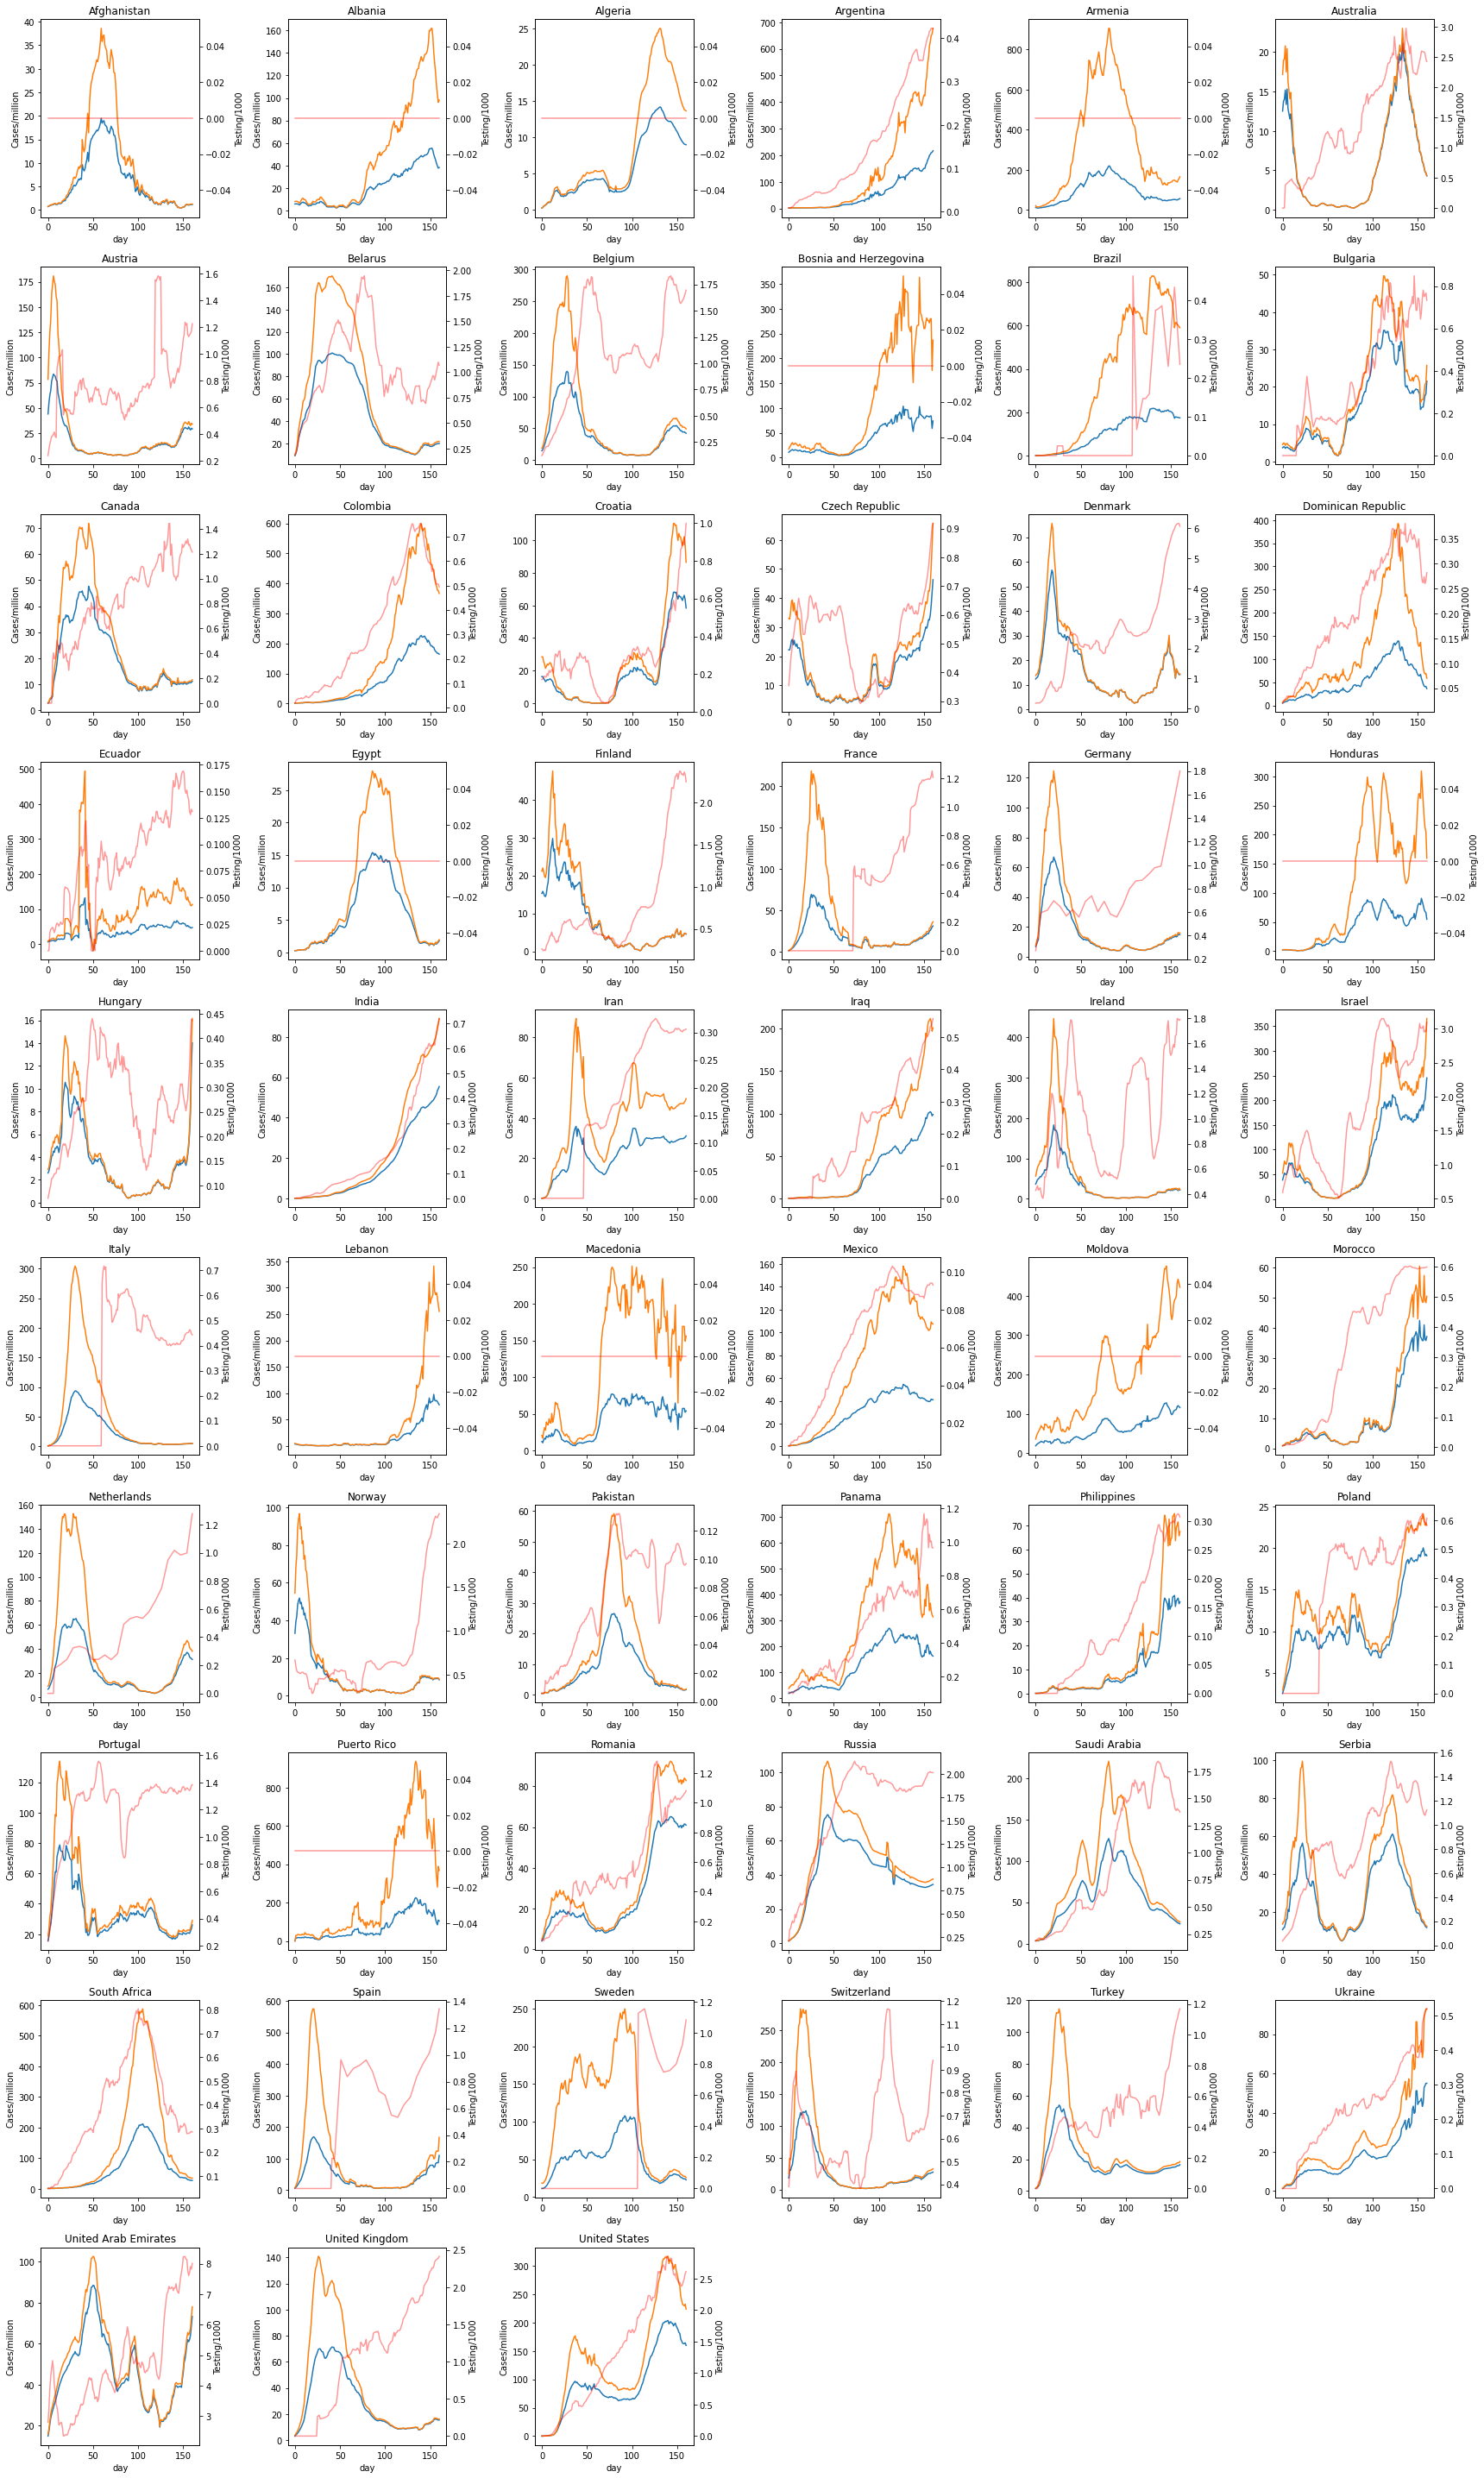

In [7]:
plot_all(countries,clusdata_all['cases'],clusdata_all['cases_nonlin'],longshort_testing_c)

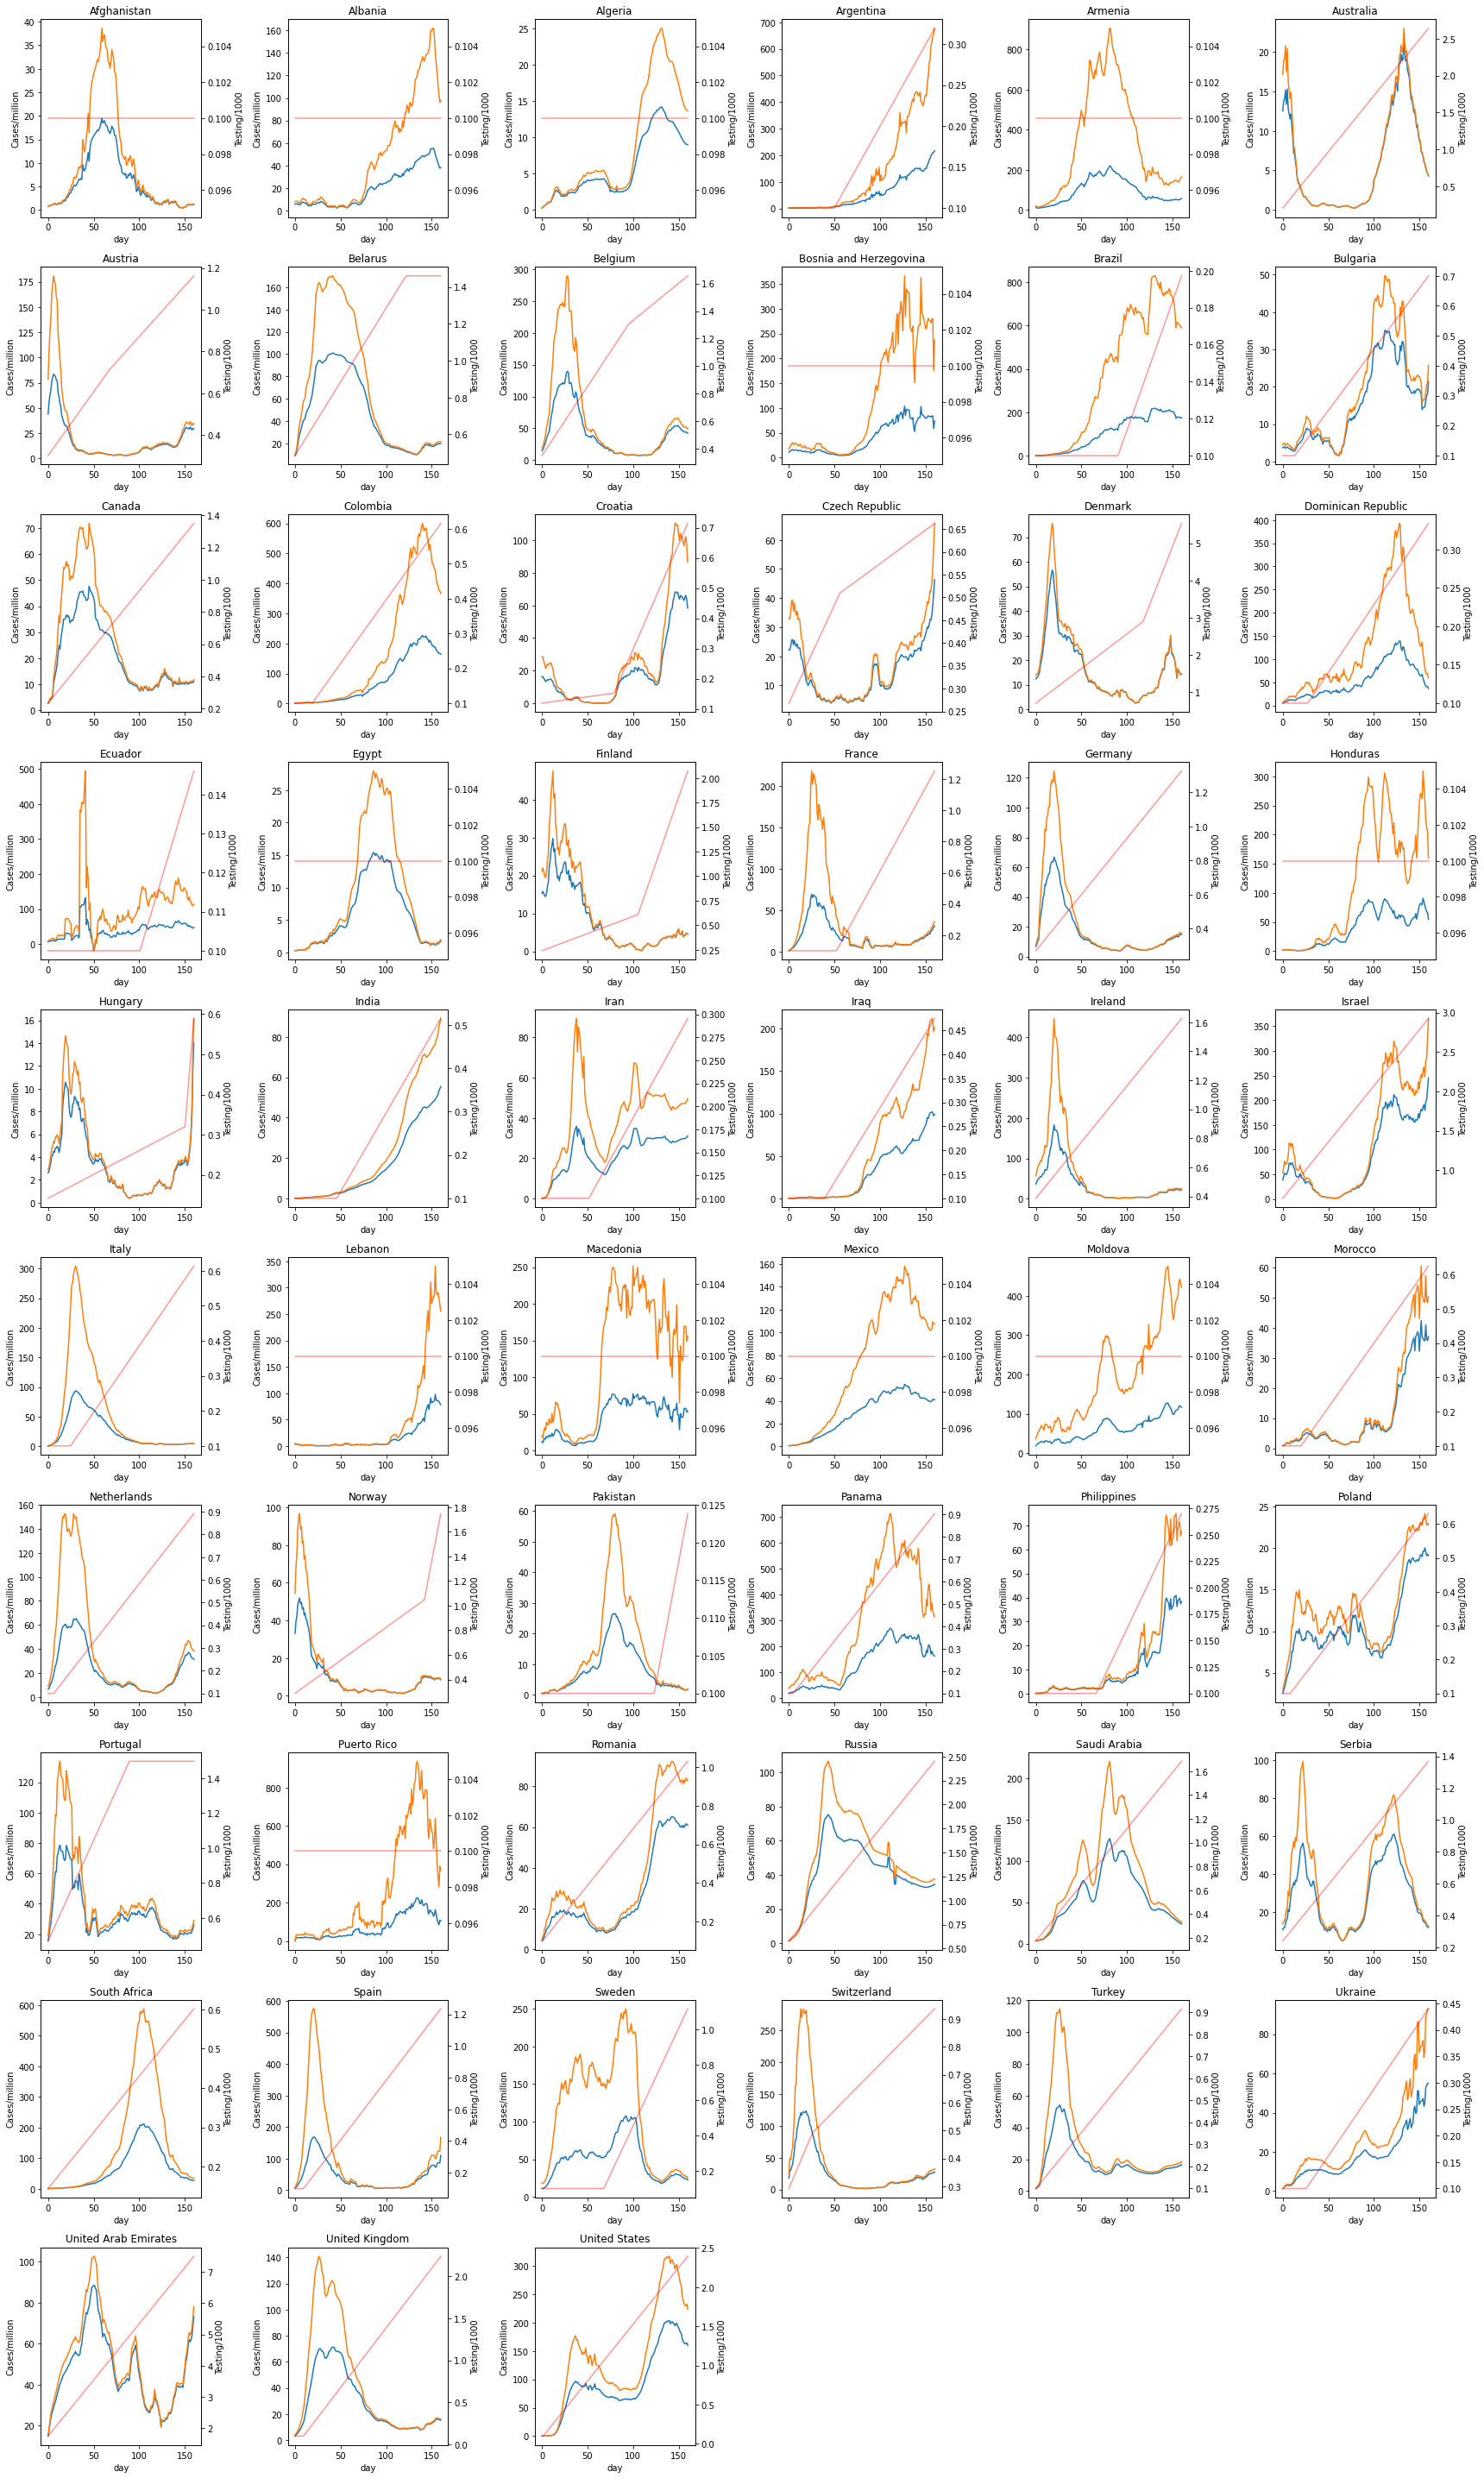

In [8]:
plot_all(countries,clusdata_all['cases'],clusdata_all['cases_nonlinr'],longshort_reg_testing_c)

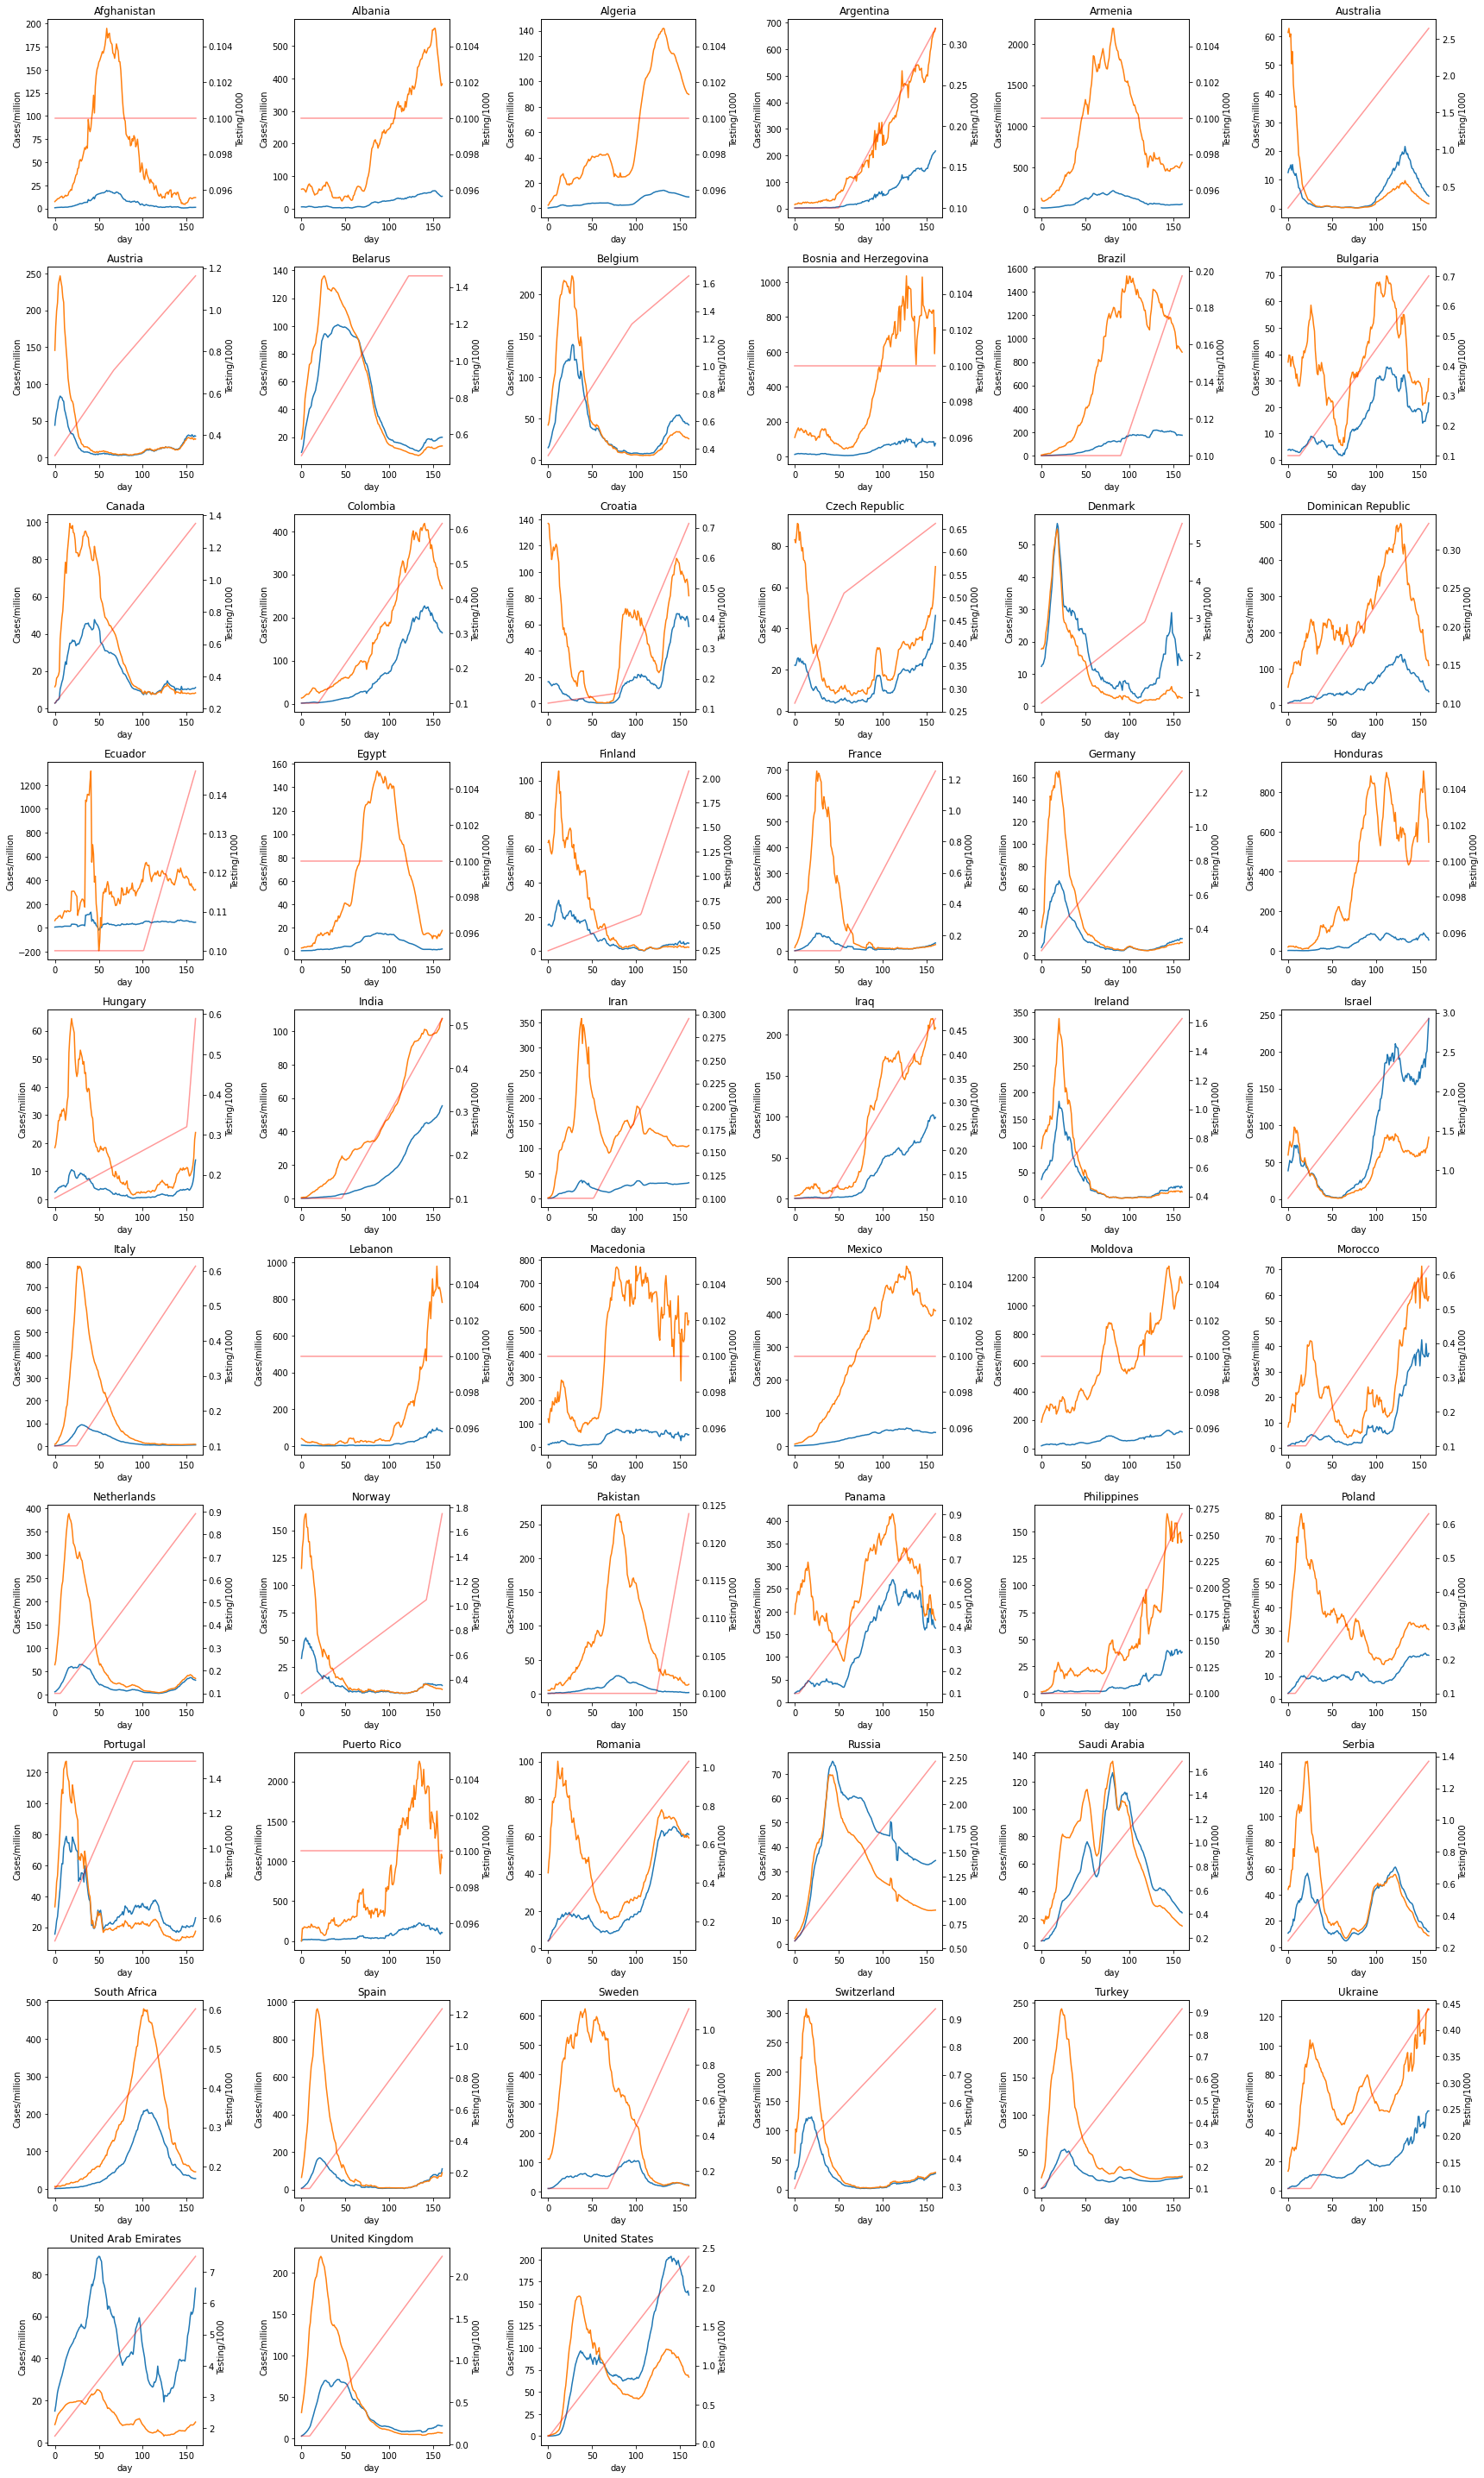

In [9]:
plot_all(countries,clusdata_all['cases'],clusdata_all['cases_pwlfit'],longshort_reg_testing_c)

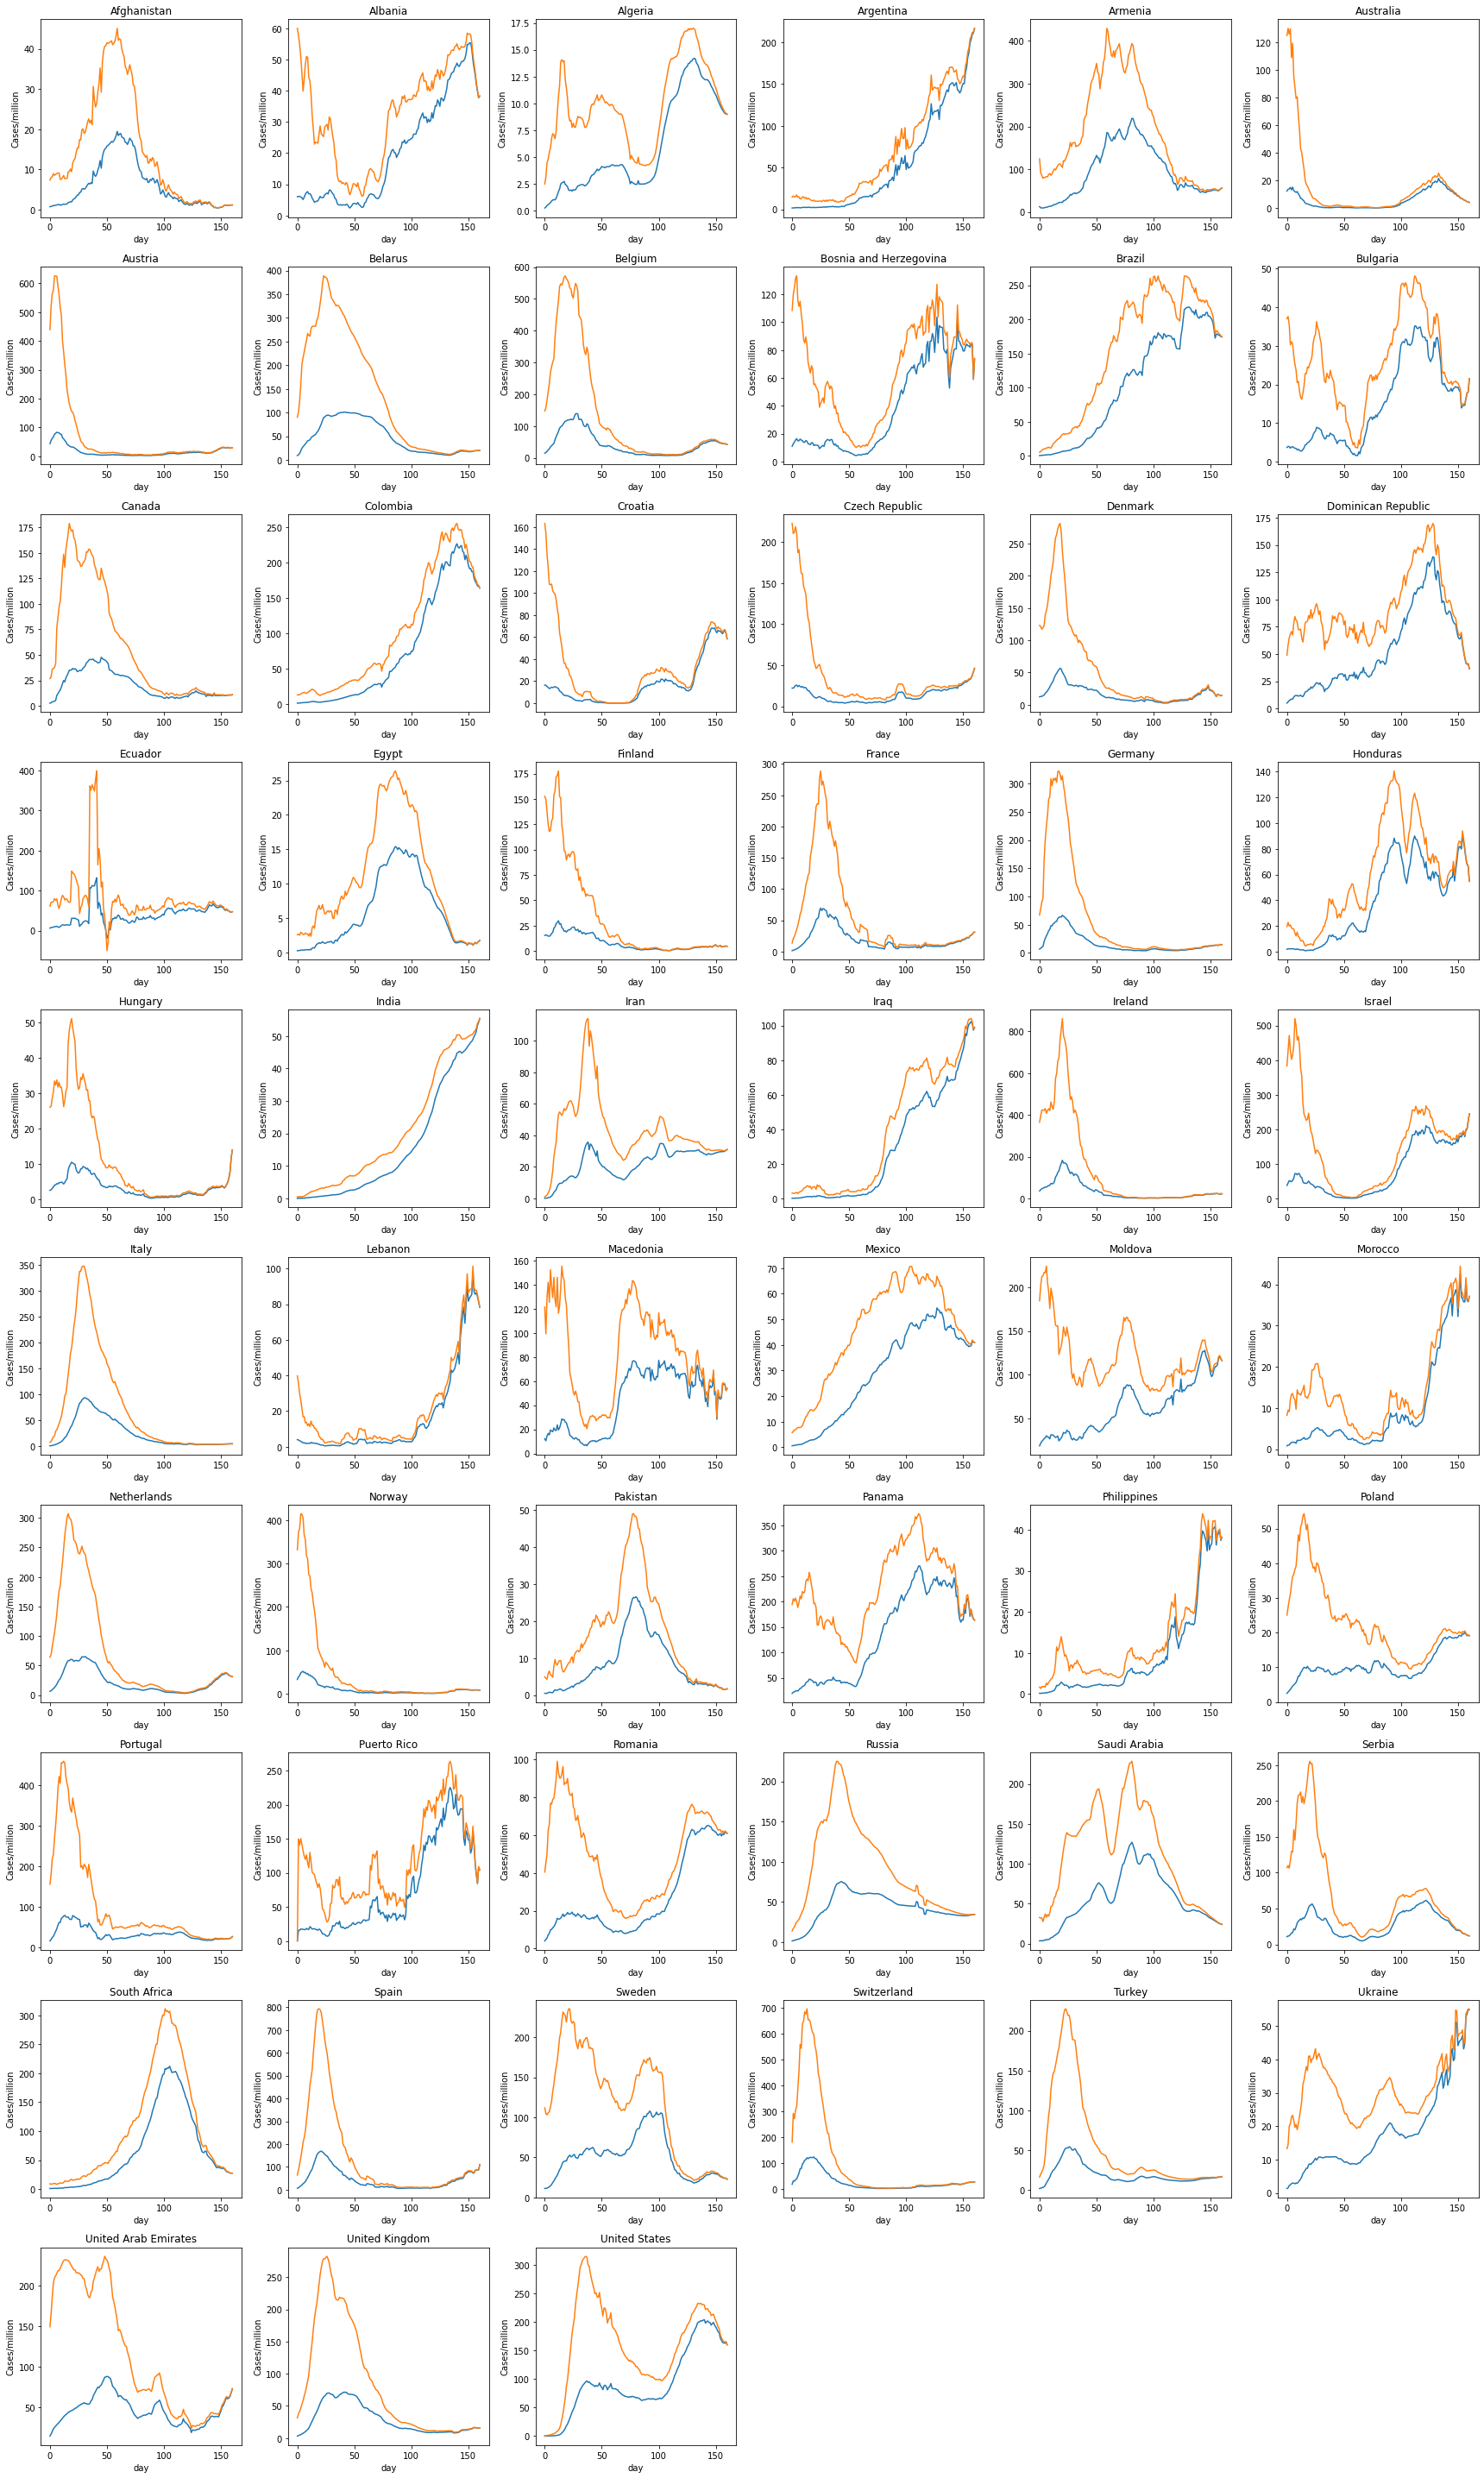

In [10]:
plot_all(lcountries,cases_raw,cases_adj_lin2020)

# ClusterFit testing

In [11]:
np.argsort(list(range(4,14)))[-1:][0]

9

16000 2 seats

In [12]:

base = '../../covid-19-JH/csse_covid_19_data/csse_covid_19_time_series/'
confirmed_jhu = get_data(base+'time_series_covid19_confirmed_global.csv')
deaths_jhu = get_data(base+'time_series_covid19_deaths_global.csv')

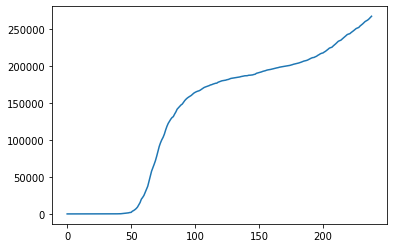

In [13]:

plt.plot(confirmed_jhu[('Germany','')])

## cases

In [14]:
foo = ClusterFit(clusdata_all['cases'],fft=True)

hdbscan found 3 clusters.
mean cluster membership probability = 0.9090201030246375


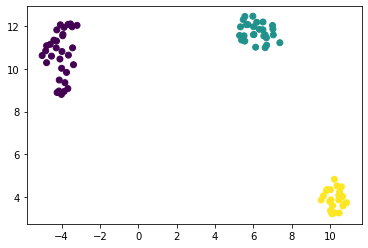

In [15]:
foo.umap_cluster(5,5)
print('mean cluster membership probability =',np.mean(foo.clus_probs))
foo.plot_umap()

In [42]:
# foo.umap_best_cluster(Nclus=3)
foo.umap_best_cluster()

found 50 clusters of size 3


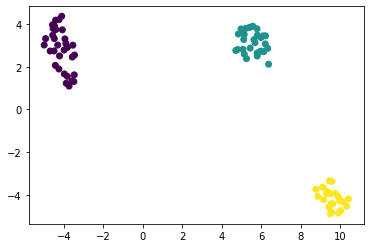

In [43]:
foo.plot_umap()

In [44]:
np.mean(foo.clus_probs)

0.950542187760555

In [45]:
clsize = []
clprobs = []
for i in range(100):
    foo.umap_cluster(i,min_size=5,diag=False)
    clsize.append(len(set(foo.clus_labels)))
    clprobs.append(np.mean(foo.clus_probs))

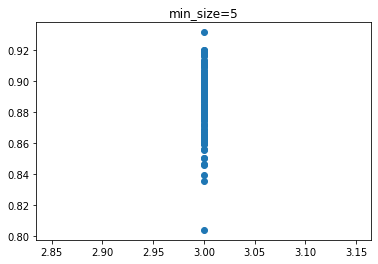

In [46]:
plt.scatter(clsize,clprobs)
plt.title('min_size=5');

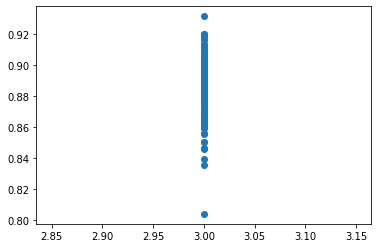

In [47]:
# min_size = 6
plt.scatter(clsize,clprobs)

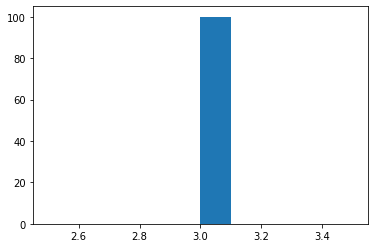

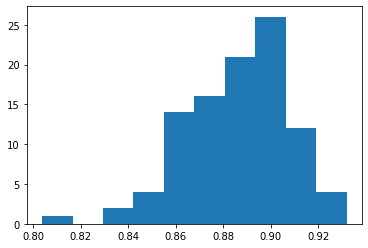

In [48]:
plt.hist(clsize);
plt.show()
plt.hist(clprobs);

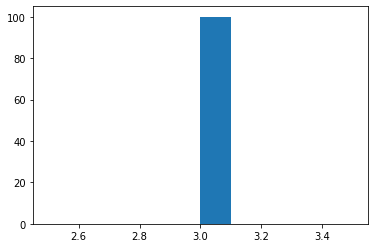

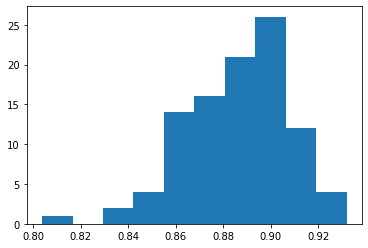

In [49]:
plt.hist(clsize);
plt.show()
plt.hist(clprobs);

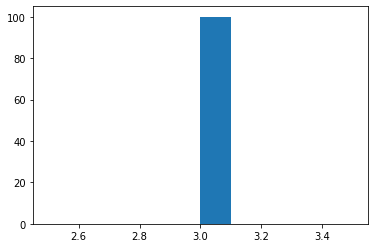

In [50]:
plt.hist(clsize);

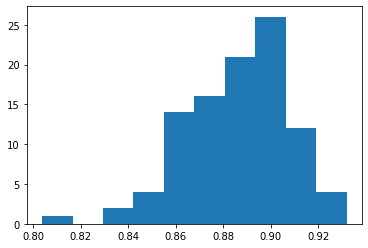

In [51]:
plt.hist(clprobs);

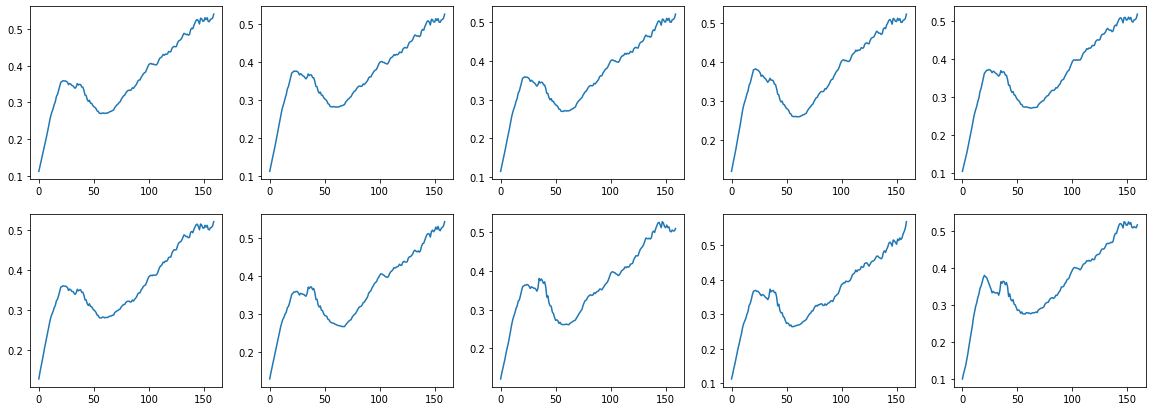

In [52]:
foo.plot_pcas()

In [53]:
clusfit_all = {}
clusfit_all['cases'] = foo

## deaths

In [116]:
foo = ClusterFit(clusdata_all['deaths'])

explained_variance_ratio:
True
['_abc_impl', '_fit', '_fit_full', '_fit_svd_solver', '_fit_truncated', '_get_param_names', 'components_', 'copy', 'explained_variance_', 'explained_variance_ratio_', 'fit', 'fit_transform', 'get_covariance', 'get_params', 'get_precision', 'inverse_transform', 'iterated_power', 'mean_', 'n_components', 'n_components_', 'n_features_', 'n_samples_', 'noise_variance_', 'random_state', 'score', 'score_samples', 'set_params', 'singular_values_', 'svd_solver', 'tol', 'transform', 'whiten']
singular values:


In [125]:
foo.umap_cluster(3) # arg = random seed

hdbscan found 3 clusters.


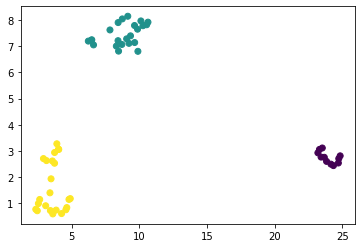

In [126]:
foo.plot_umap()

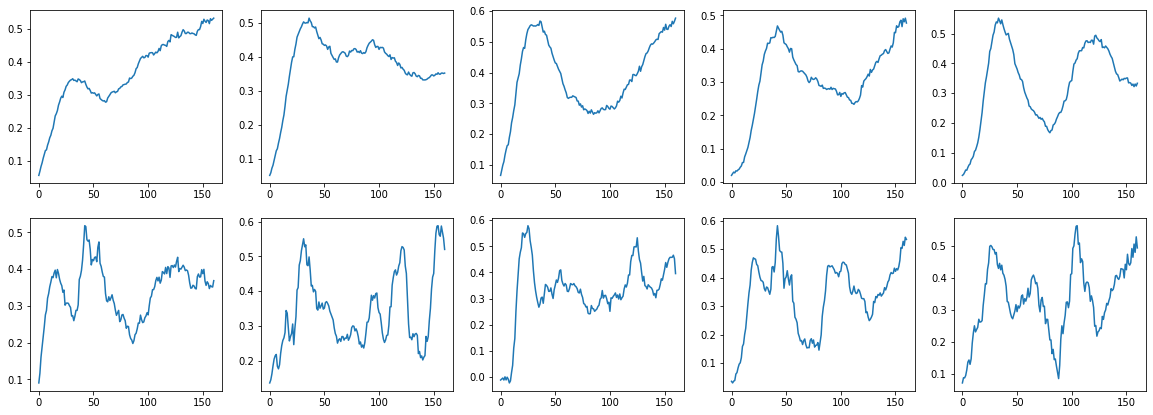

In [114]:
foo.plot_pcas()

In [110]:
clusfit_all['deaths'] = foo

In [142]:


class ClusterFit:
    """
    container class for fitting PCA, clustering
    """

    def __init__(self,
                 data,           # could be deaths/cases, raw/adjusted
                 Npca = 10,
                 outfile = ''):
        self.Npca = Npca
        self.data = data
        self.outfile = outfile
        self.dat = np.array([data[cc] for cc in data])
        # normalize the data
        for i in range(len(self.dat)):
            mx = max(self.dat[i])
            self.dat[i] = [dd/mx for dd in self.dat[i]]
        self.pca = PCA(Npca)
        self.pca.fit(self.dat)
        #print('explained_variance_ratio:')
        #print('explained_variance_ratio_' in dir(self.pca))
        #print([x for x in dir(self.pca) if '__' not in x])
        #print(self.pca.explained_variance_ratio_)
        #print('singular values:')
        #print(self.pca.singular_values_)

        self.fitted = self.pca.fit_transform(self.dat)
        self.smoothed = self.pca.inverse_transform(self.fitted)

    def plot_2components(self):
        plt.scatter(self.fitted[:,0],fitted[:,1]);

    def plot_all(self):
        max_cols=6
        max_rows=int(len(self.dat)/max_cols) + 1
        fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,3.5*max_rows))
        countries = [cc for cc in self.data]
        for idx, countrycode  in enumerate(countries):
            row = idx // max_cols
            col = idx % max_cols
            #axes[row, col].axis("off")
            axes[row, col].plot(self.dat[idx])
            axes[row, col].plot(self.smoothed[idx])
            axes[row, col].set_title(countrycode)
        for idx in range(len(lcountries),max_rows*max_cols):
            row = idx // max_cols
            col = idx % max_cols
            axes[row, col].axis("off")
        #plt.subplots_adjust(wspace=.05, hspace=.05)
        if self.outfile != '':
            plt.savefig(self.outfile)
        plt.show()

    def umap_cluster(self,random_state=0,min_size=4,diag=True):
        self.um_fit = umap.UMAP(random_state=random_state,n_neighbors=5).fit(self.fitted)
        self.um_dat = [self.um_fit.embedding_[:,i] for i in range(2)]
        tdat = np.transpose(self.um_dat)

        self.clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size)
        self.clus_labels = self.clusterer.fit_predict(tdat)
        self.clus_probs = self.clusterer.probabilities_
        if diag:
            print('hdbscan found',len(set(self.clus_labels)),'clusters.')
        
    def umap_best_cluster(self,Nclus=3,Ntries=50,minsize=4,ranstate=0):
        clusall = []
        gotone=False
        clus = {}
        for i in range(ranstate,ranstate+Ntries):
            self.umap_cluster(random_state=i,min_size=minsize,diag=False)
            if len(set(self.clus_labels)) == Nclus:
                if gotone:
                    clus['probs'].append(np.mean(self.clus_probs))
                    clus['idx'].append(i)
                else:
                    clus['probs']=[np.mean(self.clus_probs)]
                    clus['idx']=[i]
                    gotone = True
            idx = np.argsort(clus['probs'])[-1:][0]
            self.umap_cluster(random_state=clus['idx'][idx],min_size=minsize,diag=False)

    
    
    def plot_umap(self):
        plt.scatter(self.um_dat[0],self.um_dat[1],c=self.clus_labels)
        
    def plot_pcas(self):
        max_cols = 5
        max_rows = self.Npca // max_cols
        if self.Npca%max_cols>0:
            max_rows = max_rows+1
        fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,max_rows*3.5))
        for i in range(10):
            foo = np.zeros(10)
            foo[i] = 1
            mypca = self.pca.inverse_transform(foo)
            row = i // max_cols
            col = i % max_cols
            #axes[row, col].axis("off")
            axes[row, col].plot(mypca)
            


# Compare best clusters

In [130]:
cases = [c for c in clusdata_all]
cases

['deaths',
 'cases',
 'cases_lin2020',
 'cases_pwlfit',
 'cases_nonlin',
 'cases_nonlinr']

In [137]:
len(countries)

57

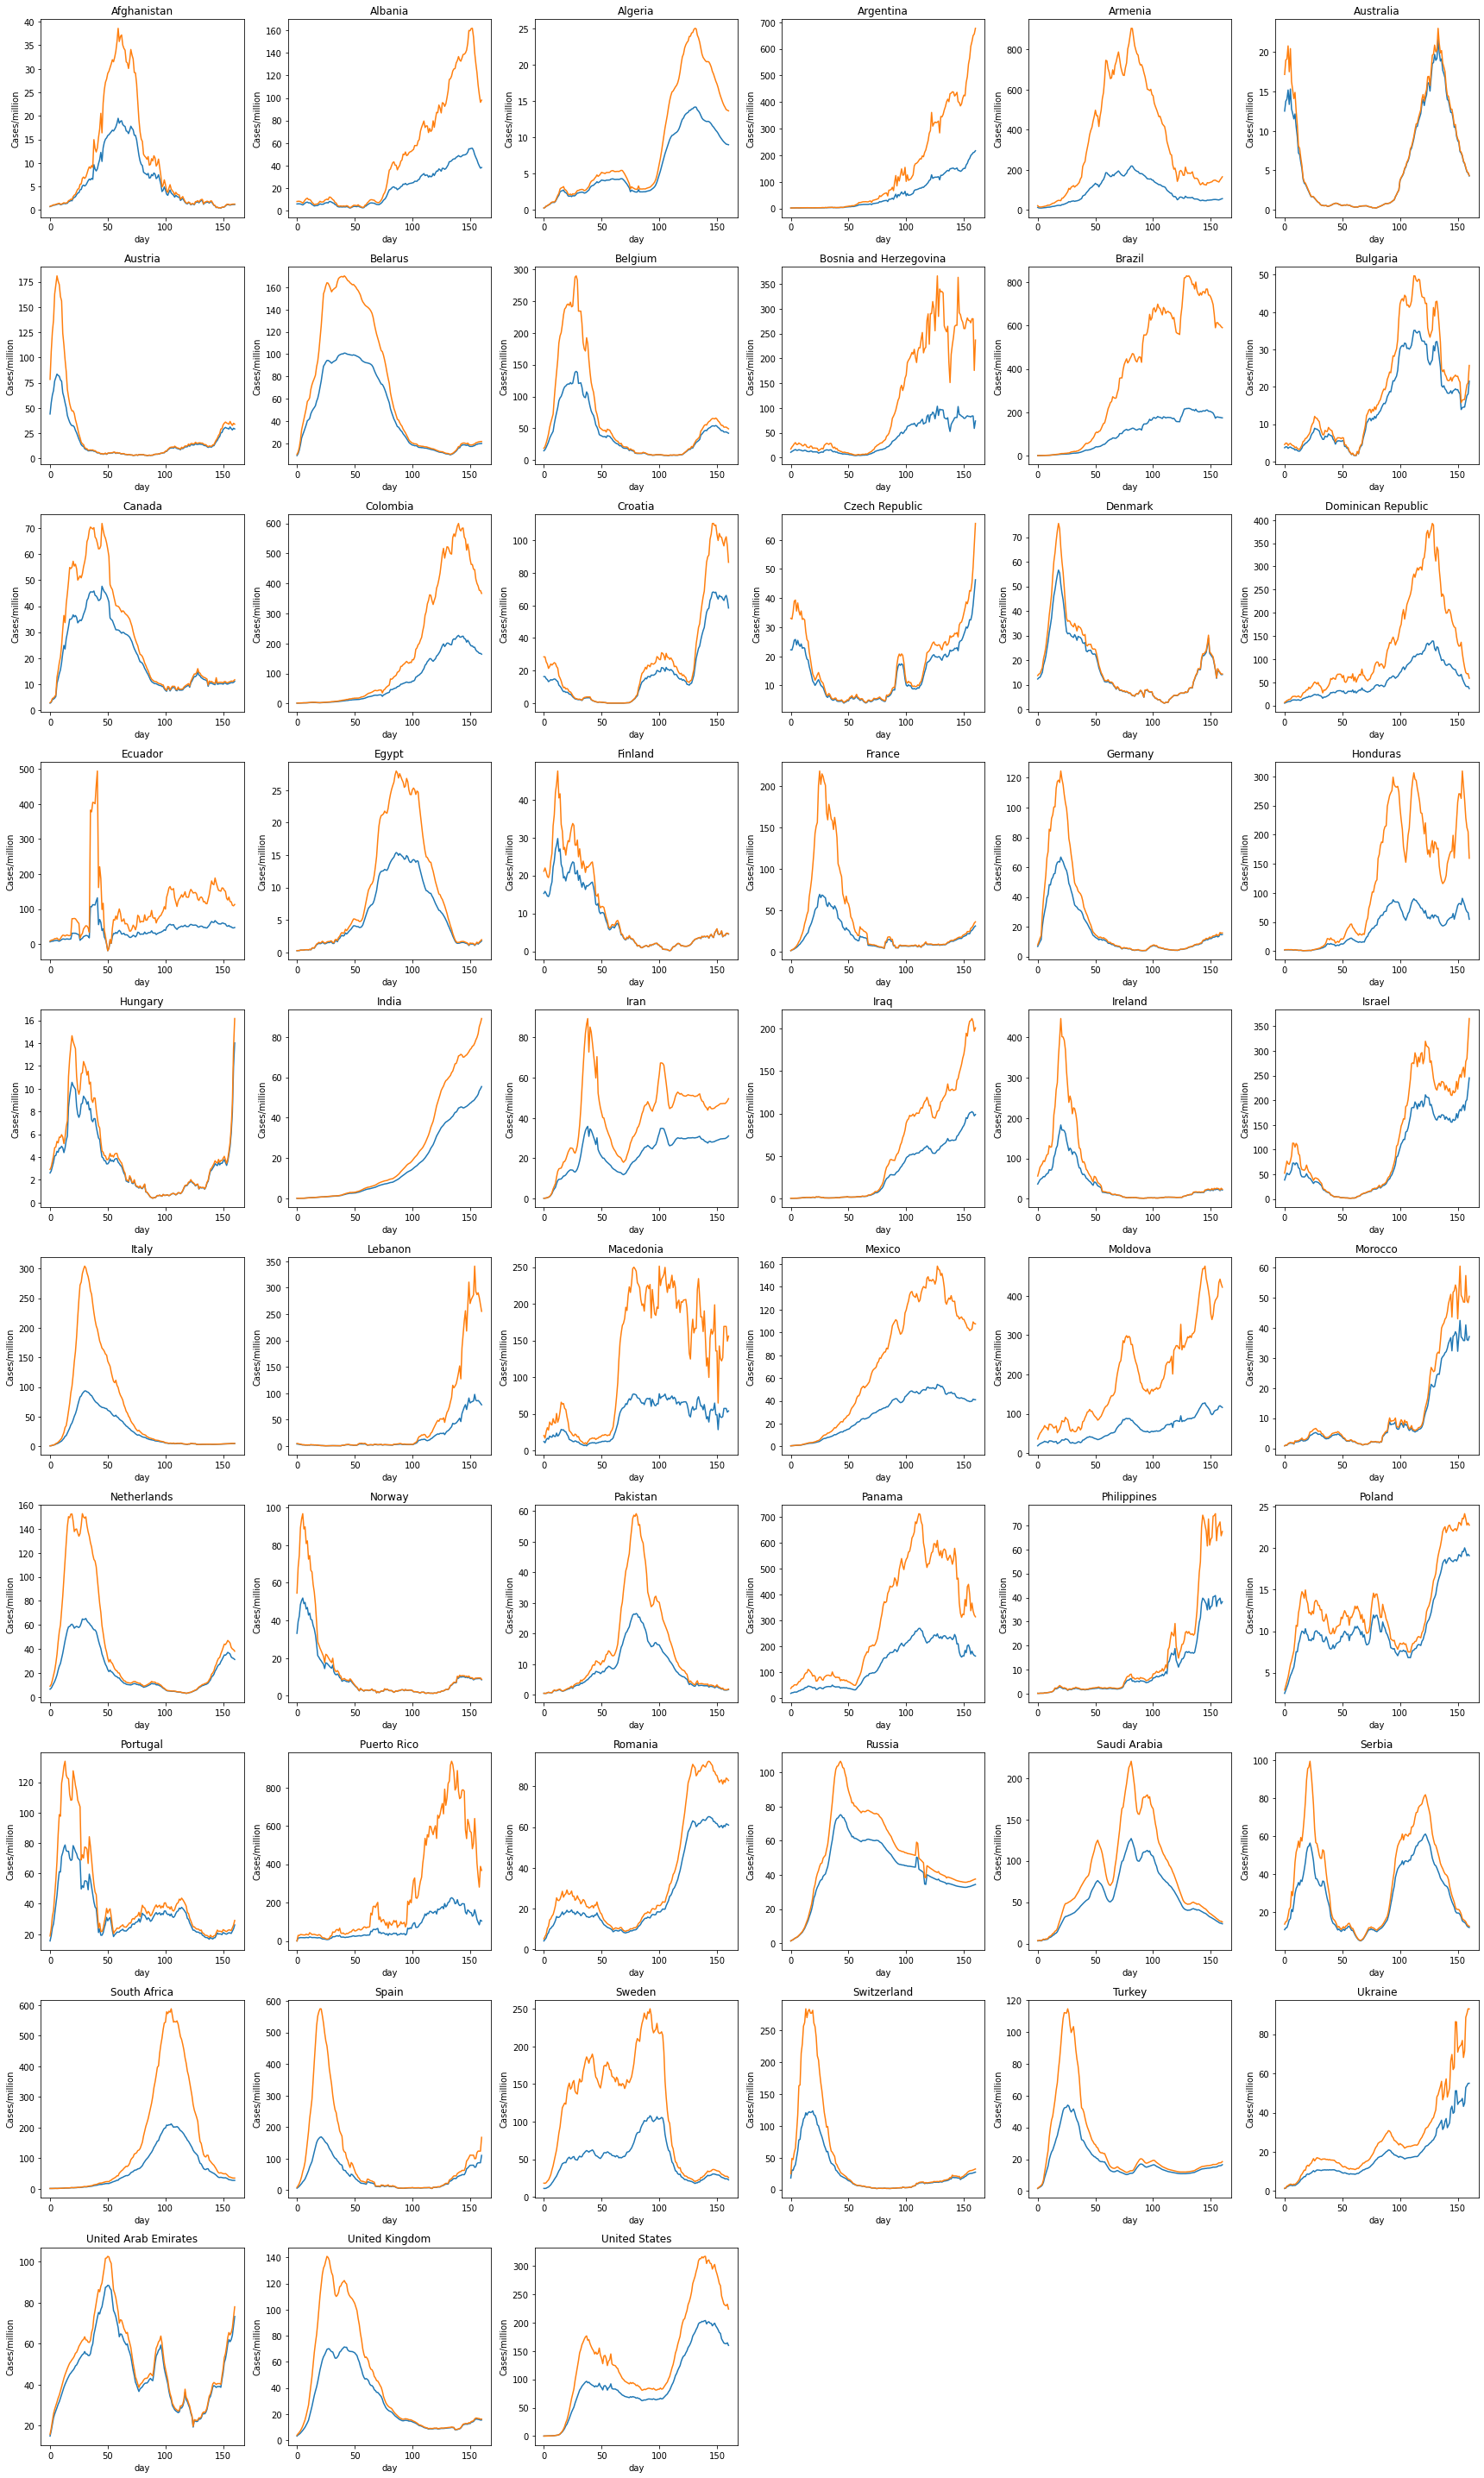

In [139]:
plot_all(countries,clusdata_all['cases'],clusdata_all['cases_nonlinr']);

In [155]:
#  Norman not sure I understand what you are printing out with "found 48 clusters of size 3" , seems wrong
res = {}
for cc in cases:
    print('doing ',cc,'...')
    mfit = ClusterFit(clusdata_all[cc])
    mfit.umap_best_cluster()
    res[cc] = mfit



doing  deaths ...
found 48 clusters of size 3
doing  cases ...
found 22 clusters of size 3
doing  cases_lin2020 ...
found 24 clusters of size 3
doing  cases_pwlfit ...
found 6 clusters of size 3
doing  cases_nonlin ...
found 14 clusters of size 3
doing  cases_nonlinr ...
found 14 clusters of size 3


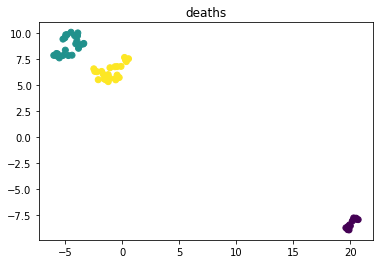

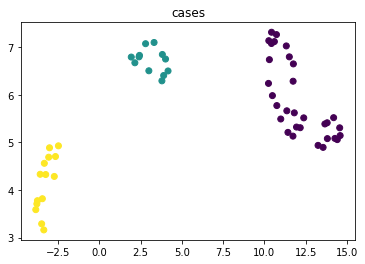

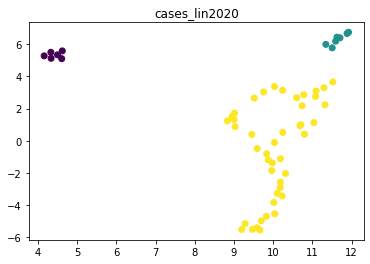

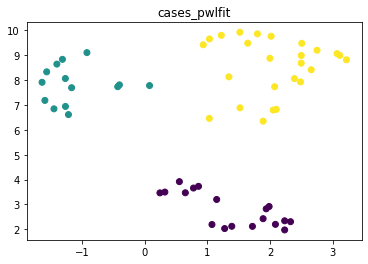

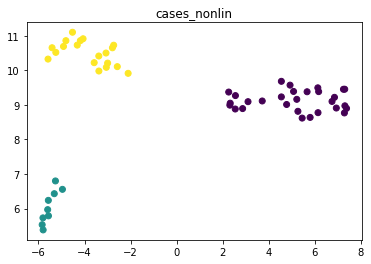

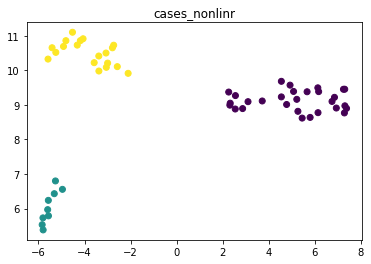

In [164]:
for rr in res:
    foo = res[rr]
    # foo.plot_umap() ########## doesn't work???
    plt.scatter(foo.um_dat[0],foo.um_dat[1],c=foo.clus_labels)
    plt.title(rr)
    plt.show()


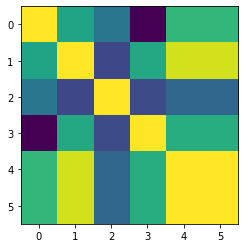

In [184]:
classes = [res[cc].clus_labels for cc in res]
corclasses = np.zeros((len(classes),len(classes)))
for i in range(len(classes)-1):
    cc = classes[i]
    for j in range(i+1,len(classes)):
        ccc = classes[j]
        cx = []
        corclasses[i,j] = mxcor(cc,ccc)
        corclasses[j,i] = corclasses[i,j]
for i in range(len(classes)):
    corclasses[i,i] = 1.0
plt.imshow(corclasses)    

In [188]:
print([(i,c,np.mean(corclasses[i,:])) for i,c in enumerate([r for r in res])])

[(0, 'deaths', 0.5752284040350646), (1, 'cases', 0.7275888265544648), (2, 'cases_lin2020', 0.4505516154452324), (3, 'cases_pwlfit', 0.5409391534391534), (4, 'cases_nonlin', 0.7713177052026982), (5, 'cases_nonlinr', 0.7713177052026982)]


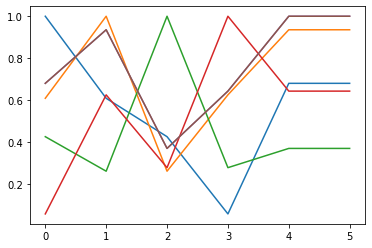

In [191]:
for i in range(6):
    plt.plot(list(range(6)),corclasses[i,:])

Note: `cases_nonlin` and `cases_nonlinr` currently same.

**Cluster correlations not outstandingly high!**

In [193]:
foo = res['cases_nonlin']

In [230]:
def plot_adj(country, data, adj = None, testing=None,  ndays=250, axis = None):
    ndays = 250
    if testing:
        # Ntests = regtests(testing,country)  # this does not work here, since data is already synchronized, use regularized data in testing 
        Ntests = testing[country]
    if axis is None:   
        fig, ax1 = plt.subplots(figsize=(12,8))
    else:
        ax1 = axis
    ax1.plot(data[country][:ndays]) 
    if adj is not None:  # already adjusted
        ax1.plot(adj[country][:ndays])
    ax1.set_title(country)
    ax1.set_ylabel('Cases/million')
    ax1.set_xlabel('day')
    if testing:
        ax2 = ax1.twinx()
        ax2.plot(Ntests[:ndays],color='red',alpha=0.4)
        ax2.set_ylabel('Testing/1000')

        
def plot_all(countries,dat,adj=None,testing=None,ndays=250):
    max_cols=6
    max_rows=int(len(countries)/max_cols) + 1
    fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,4*max_rows))

    for idx, country  in enumerate(countries):
        row = idx // max_cols
        col = idx % max_cols
        plot_adj(country,dat,adj,testing,ndays,axis=axes[row,col])
    for idx in range(len(countries),max_rows*max_cols):
        row = idx // max_cols
        col = idx % max_cols
        axes[row, col].axis("off")
    #plt.subplots_adjust(wspace=.05, hspace=.05)
    fig.tight_layout()
    #for ax in fig.get_axes():
    #    ax.label_outer()
    plt.show()


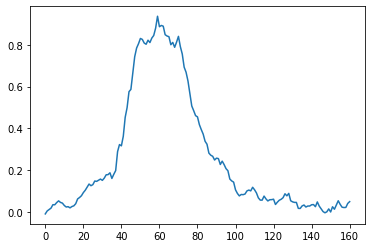

In [231]:
plt.plot(foo.smoothed[0])

In [232]:
len(foo.dat[0,:])

161

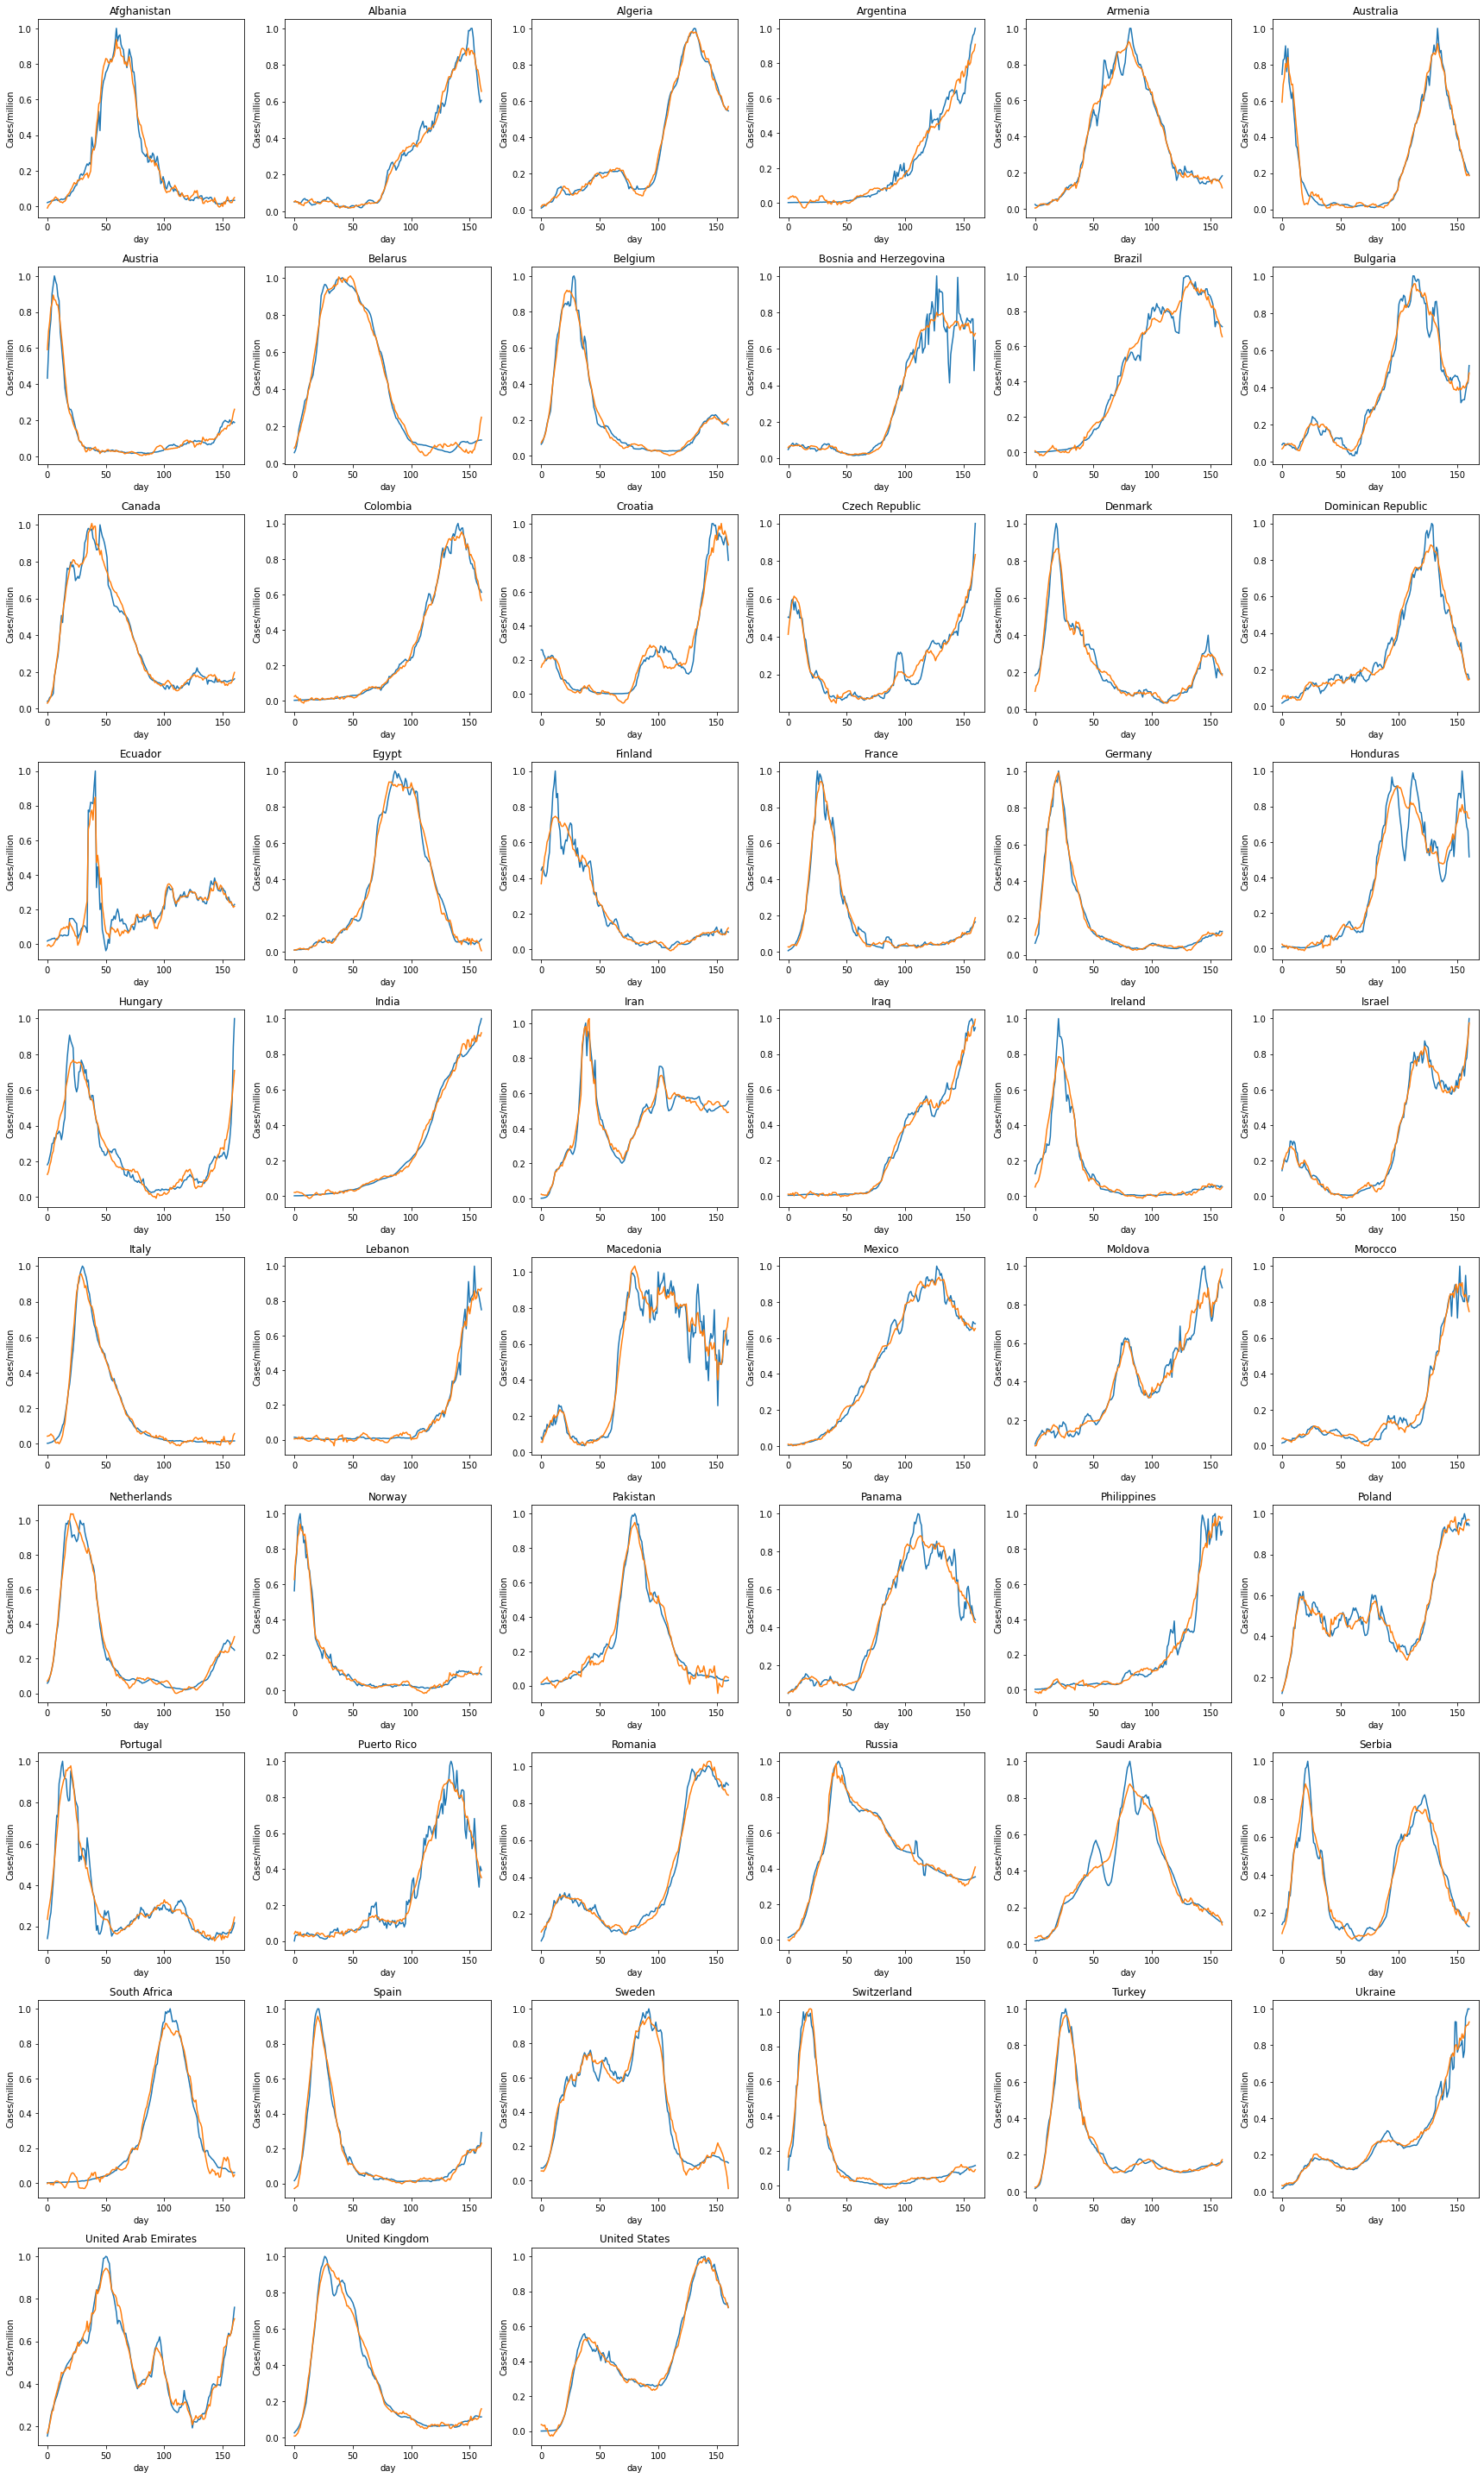

In [233]:
dat1 = {countries[i]:foo.dat[i,:] for i in range(len(countries))}
dat2 = {countries[i]:foo.smoothed[i,:] for i in range(len(countries))}
plot_all(countries,dat1,dat2)

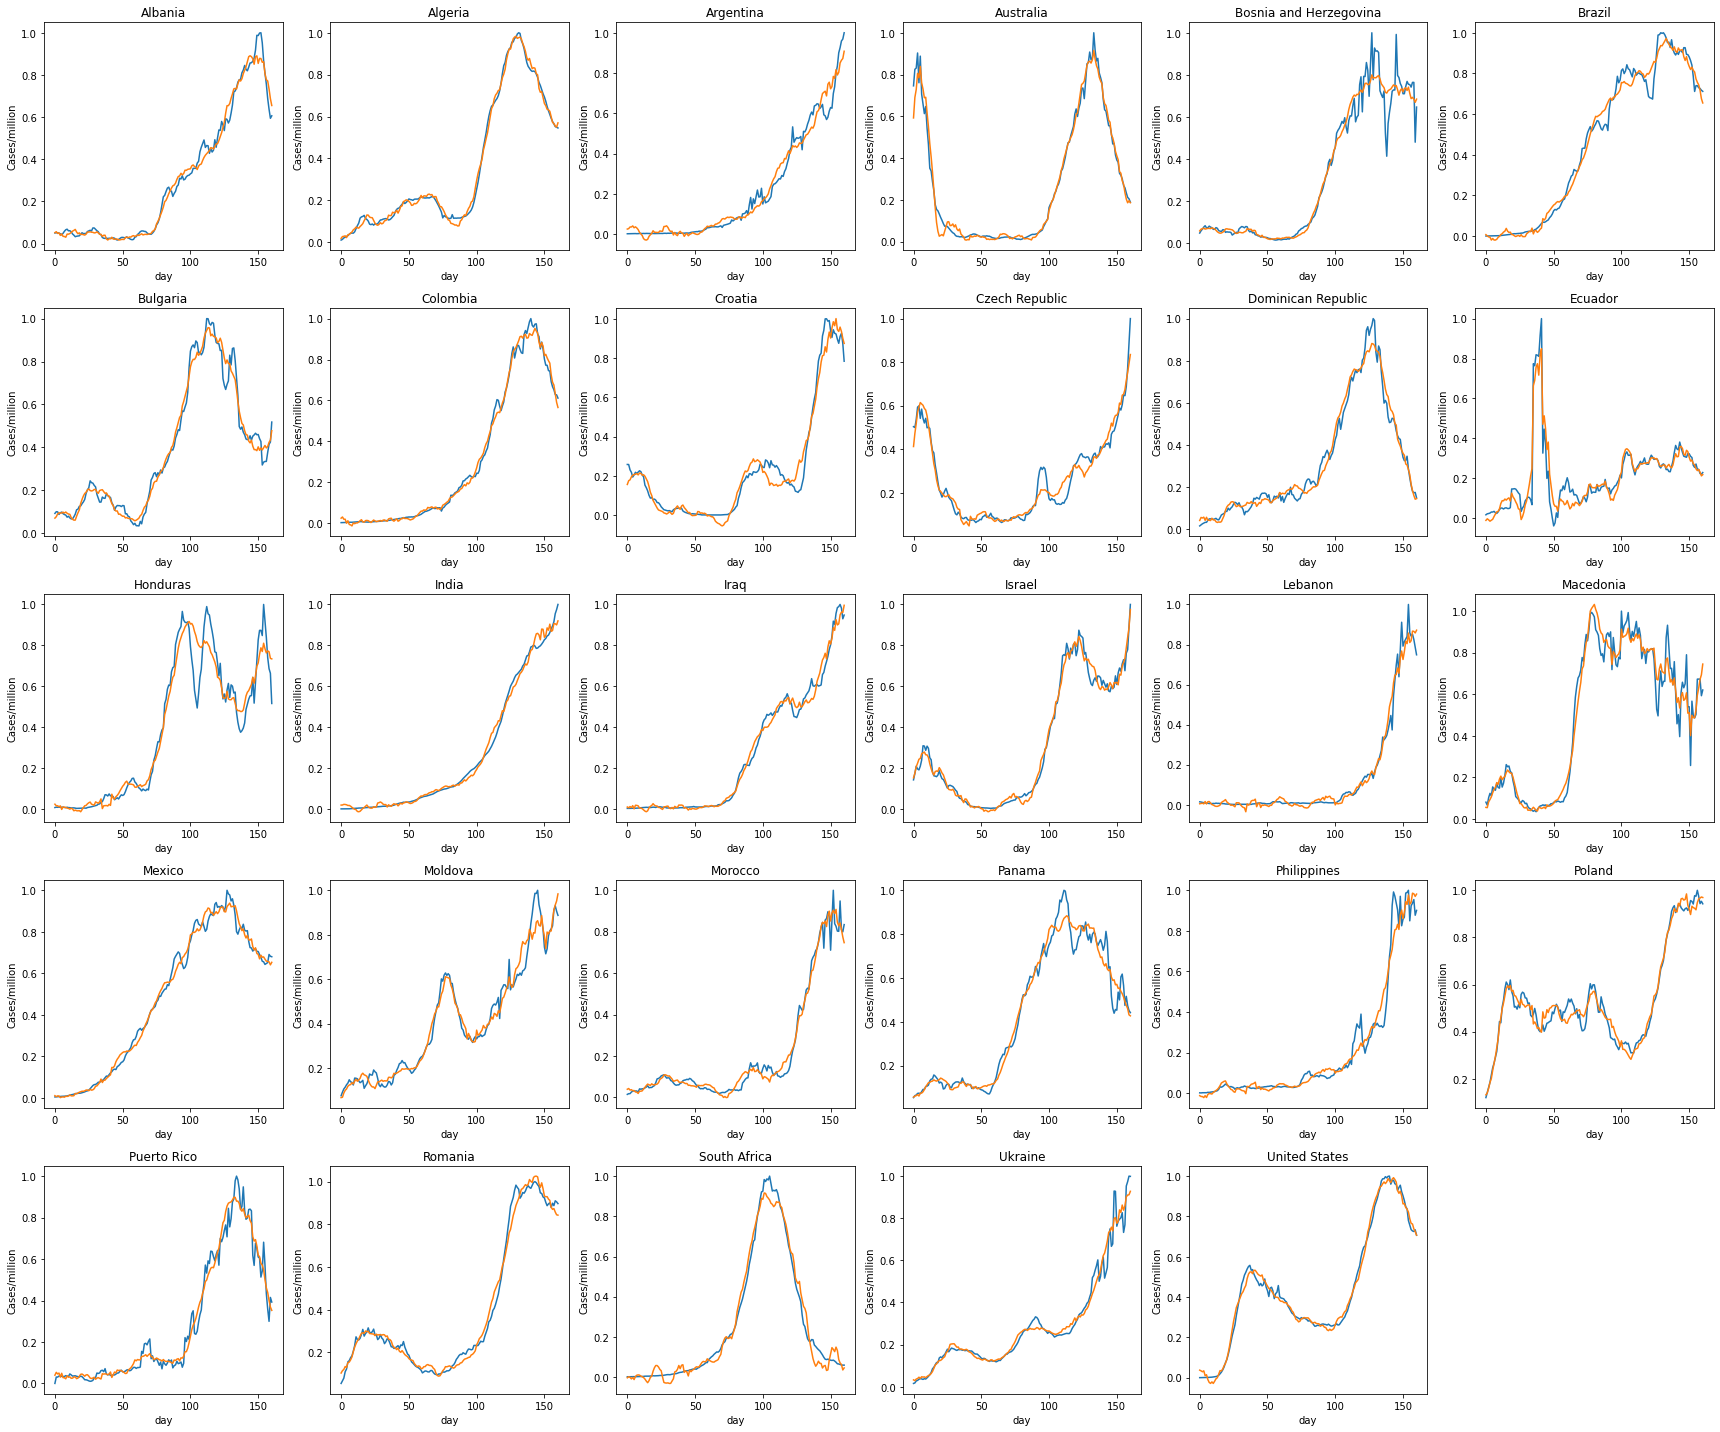

In [236]:
cc = 'cases_nonlin'
clus0 = [i for i,x in enumerate(res[cc].clus_labels) if x==0]

count0 = [countries[i] for i in clus0]
plot_all(count0,dat1,dat2)

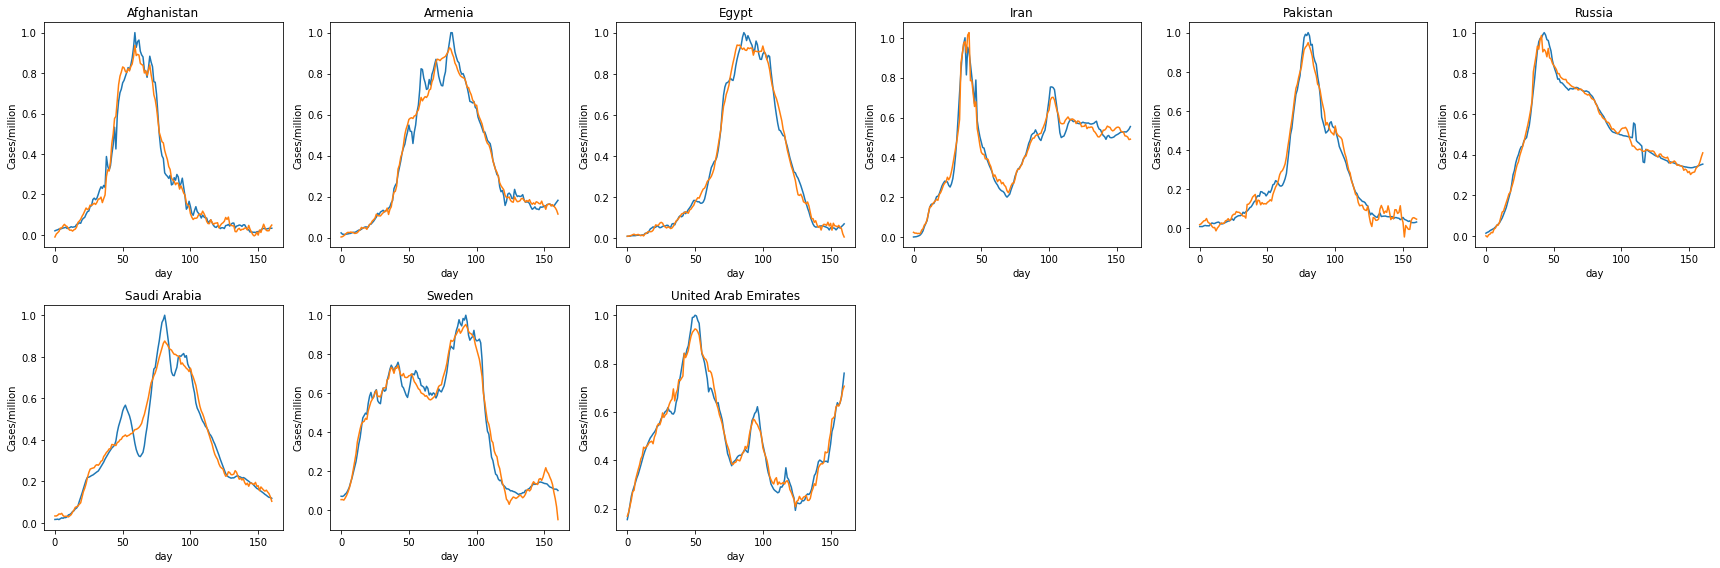

In [238]:
cc = 'cases_nonlin'
clus = [i for i,x in enumerate(res[cc].clus_labels) if x==1]

count = [countries[i] for i in clus]
plot_all(count,dat1,dat2)

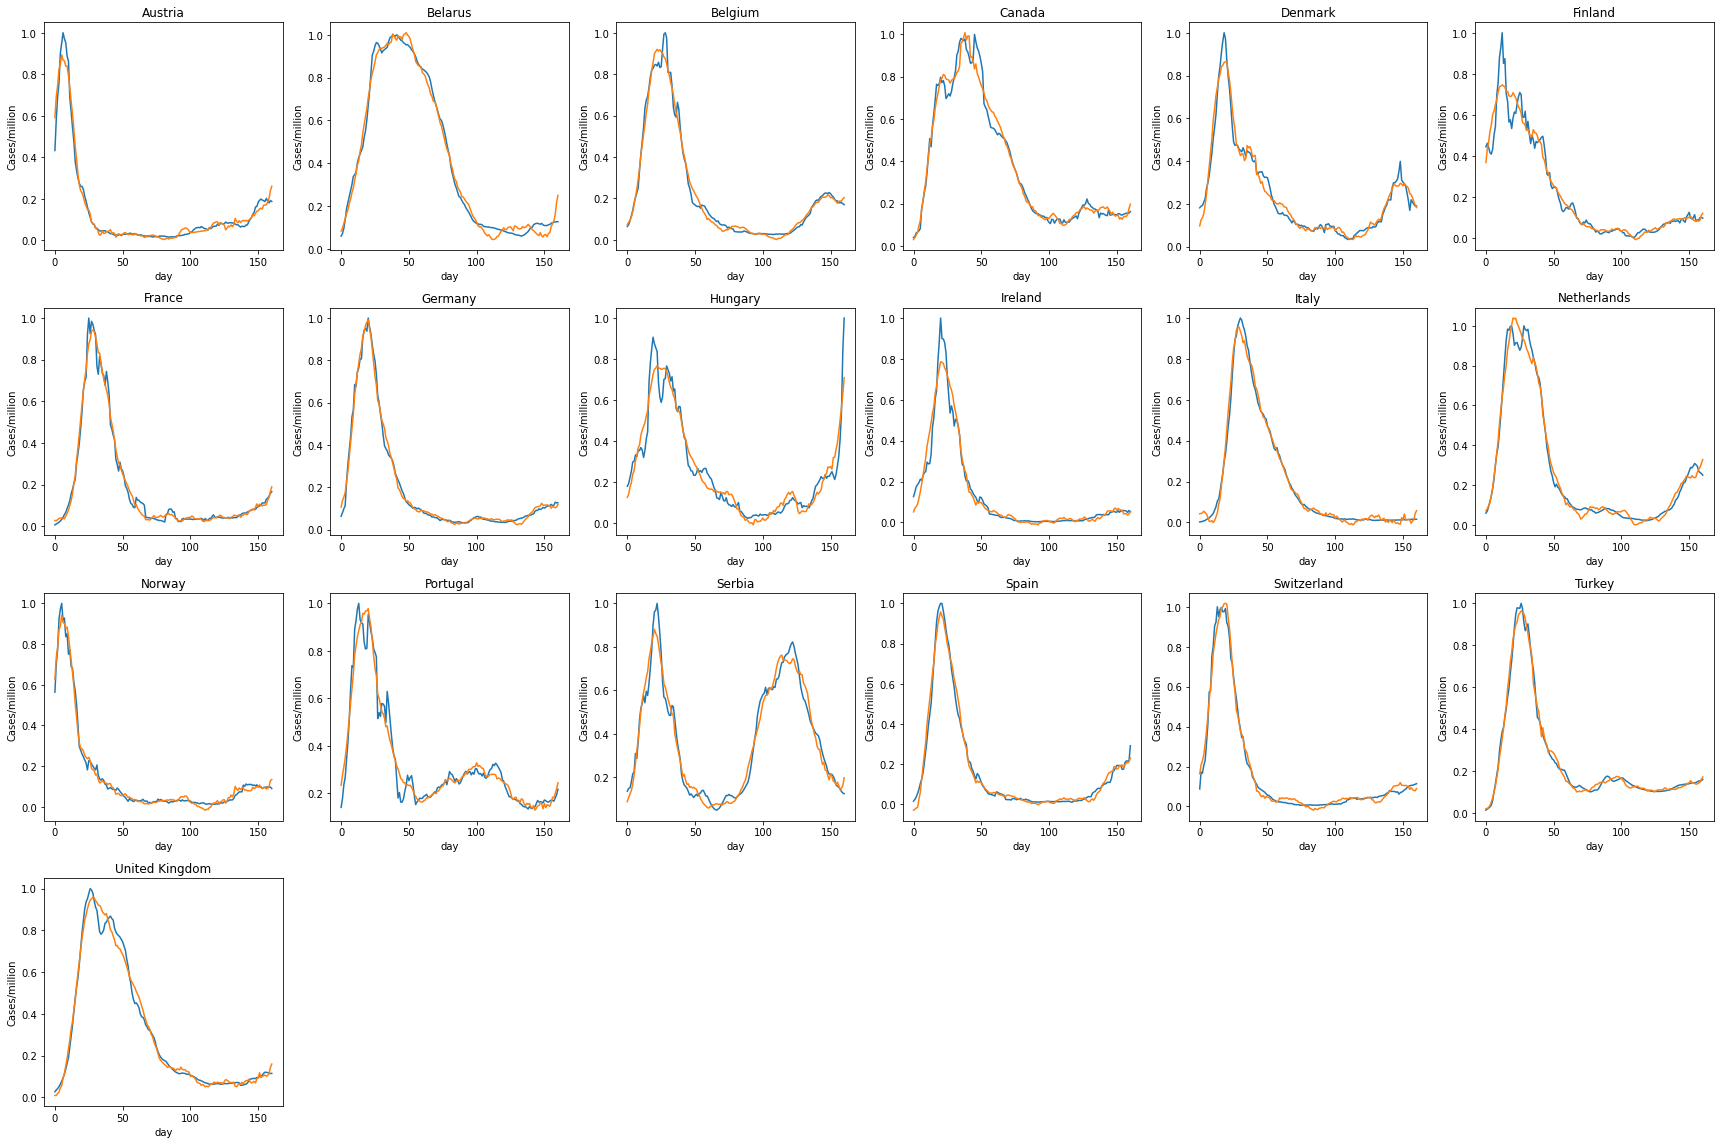

In [239]:
cc = 'cases_nonlin'
clus = [i for i,x in enumerate(res[cc].clus_labels) if x==2]

count = [countries[i] for i in clus]
plot_all(count,dat1,dat2)